# 원티드 온보딩코스 2주차 주제: 모두컴퍼니 앱 이용자 별 향후 이용 건수 예측
## 이용자 별 결제 이력을 바탕으로 한 향후 한 달간 이용 건수(COUNT) 예측

### Metric: MSE, MAE (**RMSE는 안되나?**)
### random_seed는 42로 고정

* 모델링에 대한 결과 .ipynb 파일 (team1_onboarding_week2_analysis.ipynb)
* np.random.seed(42) 설정
* Input : X데이터 : [user_id, +@]
* Output : Count column 예측값
* 2020.01.01~2020.09.30 : Training Data
* 2020.10.01~2020.12.31 : Test Data
* 2020.10.01~2020.12.31 구간에 대한 MSE, MAE 계산값
* 요일별 이용량에 대한 분석 - EDA

In [649]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

import warnings
warnings.filterwarnings('ignore')

# import statsmodels.api as sm

# scikit learn 관련 
random_state = np.random.seed(42)
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 모두컴퍼니
https://www.moduparking.com/

* 데이터에 대한 파악을 용이하게 돕기 위해 서비스 파악 필요
* 맵에서 주차장 정보 확인하고 결제

# Data Load

In [314]:
user = pd.read_csv('./모두컴퍼니data/실전db.csv')
weather = pd.read_csv('./모두컴퍼니data/서울시_기상데이터.csv', encoding='cp949')
# traffic = pd.read_excel('./모두컴퍼니data/2020교통량통합.xlsx')
print(user.shape)
print(weather.shape)
print(traffic.shape)
display(user.head())
display(weather.head())
# display(traffic.head(3))

(879271, 8)
(8760, 10)
(98820, 29)


,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR


,지점,일시,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도
0,108,2020-01-01 1:00,-5.90,NaN,1.70,40,NaN,NaN,-2.40,3.20
1,108,2020-01-01 2:00,-5.70,NaN,0.10,42,NaN,NaN,-2.40,3.10
2,108,2020-01-01 3:00,-5.60,0.00,0.00,46,NaN,NaN,-2.70,3.10
3,108,2020-01-01 4:00,-5.40,NaN,0.00,50,NaN,NaN,-2.50,3.00
4,108,2020-01-01 5:00,-5.20,NaN,0.00,55,NaN,NaN,-2.20,3.00


# 유저데이터 전처리 및 EDA

In [315]:
# 컬럼 소문자로 변경
lower_col = user.columns.str.lower().tolist()
user.columns = lower_col
user.head()

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR


In [316]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879271 entries, 0 to 879270
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_id     879271 non-null  int64 
 1   join_date   879271 non-null  object
 2   d_type      879271 non-null  object
 3   store_id    879271 non-null  int64 
 4   goods_type  879271 non-null  object
 5   date        879271 non-null  object
 6   count       879271 non-null  int64 
 7   ad1         879271 non-null  object
dtypes: int64(3), object(5)
memory usage: 53.7+ MB


In [317]:
# JOIN_DATE 데이터 타입을 날짜 타입으로 변경
user['join_date'] = pd.to_datetime(user['join_date'])
user['date'] = pd.to_datetime(user['date'])
display(user.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879271 entries, 0 to 879270
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     879271 non-null  int64         
 1   join_date   879271 non-null  datetime64[ns]
 2   d_type      879271 non-null  object        
 3   store_id    879271 non-null  int64         
 4   goods_type  879271 non-null  object        
 5   date        879271 non-null  datetime64[ns]
 6   count       879271 non-null  int64         
 7   ad1         879271 non-null  object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 53.7+ MB


None

In [318]:
# object 타입 컬럼 value_counts()
print(len(user['d_type'].value_counts()))
print(len(user['goods_type'].value_counts()))
print(len(user['ad1'].value_counts()))

3
4
85


* **상관관계 파악을 위해 D_TYPE과 GODDS_TYPE 레이블인코딩 진행**
* **이후 두 컬럼이 유의미하다고 판단**
* user2 데이터 생성

In [319]:
user2 = user.copy()
d_type_encoder = LabelEncoder()
d_type_encoder.fit(user2['d_type'])
d_type_labels = d_type_encoder.transform(user2['d_type'])
user2['d_type_labels'] = d_type_labels

goods_type_encoder = LabelEncoder()
goods_type_encoder.fit(user2['goods_type'])
goods_type_labels = goods_type_encoder.transform(user2['goods_type'])
user2['goods_type_labels'] = goods_type_labels
user2.head()

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,d_type_labels,goods_type_labels
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,0,0
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,1,0
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,1,0
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,1,2
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,0,2


In [320]:
print(f'd_type 인코딩 클래스: {d_type_encoder.classes_}')
print(f'goods_type 인코딩 클래스: {goods_type_encoder.classes_}')

d_type 인코딩 클래스: ['AA' 'BB' 'CC']
goods_type 인코딩 클래스: ['A' 'B' 'C' 'D']


* d_type
    * AA : 0
    * BB : 1
    * CC : 2
<br><br>
* goods_type
    * A : 0
    * B : 1
    * C : 2
    * D : 3

In [321]:
# 기존 컬럼 삭제
user2.drop(columns=['d_type', 'goods_type'], axis=1, inplace=True)
user2.head(2)

,user_id,join_date,store_id,date,count,ad1,d_type_labels,goods_type_labels
0,2858,2014-01-07,1892,2020-01-01,1,GN,0,0
1,5647,2014-02-14,182009,2020-01-01,1,J,1,0


In [322]:
user2['d_type_labels'].value_counts()

0    493166
1    384541
2      1564
Name: d_type_labels, dtype: int64

## 컬럼별 데이터 특징

In [323]:
user2.pivot_table(index='join_date', values='user_id', aggfunc='count').\
                                            reset_index().sort_values(by='join_date', ascending=True).head()

,join_date,user_id
0,1970-01-01,1093
1,2013-12-16,2
2,2013-12-17,26
3,2013-12-18,1
4,2013-12-21,2


In [324]:
user2.groupby(['join_date'])['user_id'].count().reset_index().sort_values(by='join_date').head()

,join_date,user_id
0,1970-01-01,1093
1,2013-12-16,2
2,2013-12-17,26
3,2013-12-18,1
4,2013-12-21,2


In [325]:
user2.loc[user2['join_date'] == '1970-01-01', 'user_id'].nunique()

264

* 가입년도가 1970년인 유저수 unique 값: 264명(row 자체로는 1093 row)

In [326]:
user2.describe()

,user_id,store_id,count,d_type_labels,goods_type_labels
count,879271.00,879271.00,879271.00,879271.00,879271.00
mean,1206565.74,149599.96,1.03,0.44,0.50
std,420652.89,68898.04,0.51,0.50,0.83
min,224.00,4.00,1.00,0.00,0.00
25%,900576.00,92437.00,1.00,0.00,0.00
50%,1321440.00,173059.00,1.00,0.00,0.00
75%,1542416.50,220661.00,1.00,1.00,1.00
max,1830598.00,231465.00,61.00,2.00,3.00


* count 컬럼 min value : 1
* count 컬럼 max value : 61
* 1사분위수, 중위값, 3사분위수 모두 value = 1 (max값은 이상치일 확률 높음)

In [327]:
user2['count'].value_counts().sort_values(ascending=False).head(8)

1    863775
2     13519
3      1061
4       271
5       136
6        66
7        45
9        25
Name: count, dtype: int64

<AxesSubplot:>

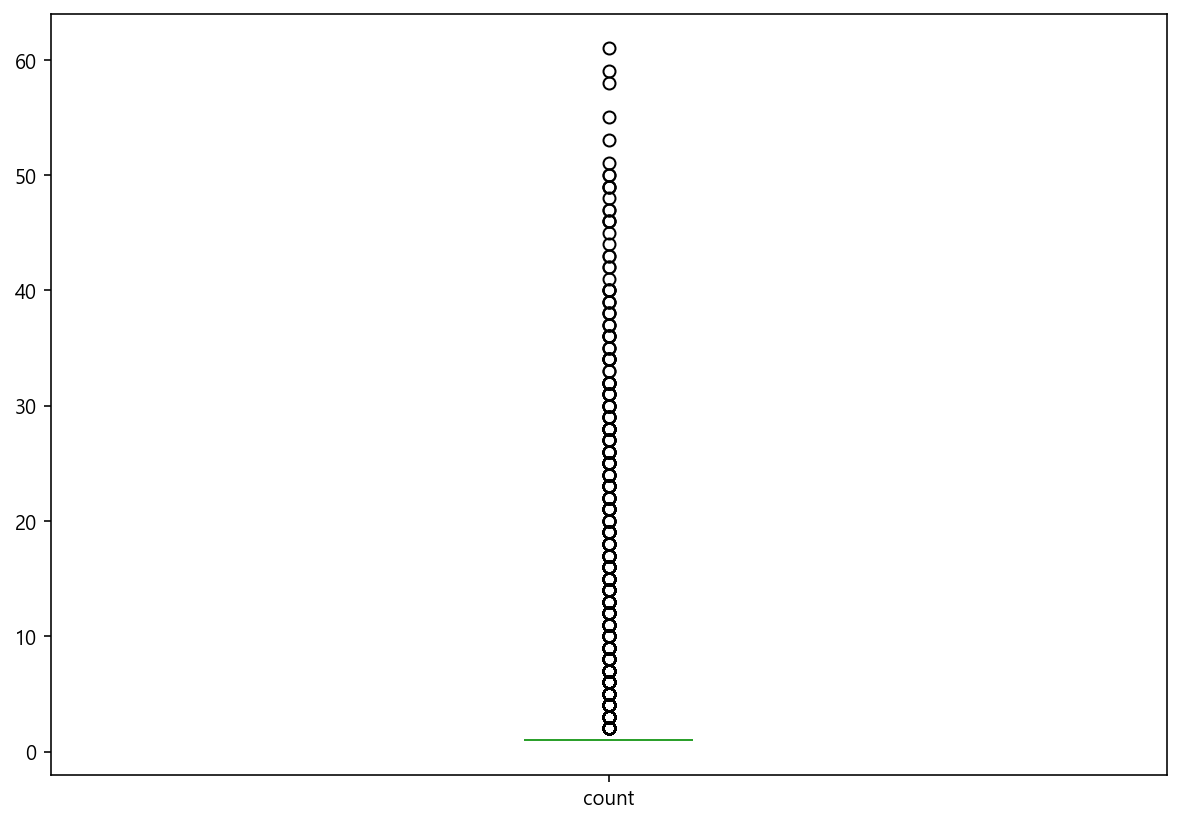

In [328]:
user2['count'].plot(kind='box', figsize=(10, 7))

In [329]:
print(len(user2.query('count > 5')))
print(len(user2.query('count > 10')))
print(len(user2.query('count > 20')))

509
337
175


**<하루 결제 건수>** <br>
* count가 20개 넘는 경우 509개
* count가 10개 넘는 경우 337개
* count가 20개 넘는 경우 175개
<br> --> 이상치? --> drop? (기준 필요)

In [330]:
user.describe(include=['O'])

,d_type,goods_type,ad1
count,879271,879271,879271
unique,3,4,85
top,AA,A,J
freq,493166,609790,179383


In [331]:
user2.describe(include=['O', 'datetime'])

,join_date,date,ad1
count,879271,879271,879271
unique,2352,366,85
top,2020-02-24 00:00:00,2020-11-07 00:00:00,J
freq,3611,3765,179383
first,1970-01-01 00:00:00,2020-01-01 00:00:00,NaN
last,2020-12-31 00:00:00,2020-12-31 00:00:00,NaN


* JOIN_DATE(가입일): 1970-01-01 ~ 2020-12-31
* DATE() : 2020-01-01 ~ 2020-12-31
* D_TYPE: AA(0)가 제일 많음
* GOODS_TYPE: A(0)가 제일 많음
* AD1: J가 제일 많음

Text(0.5, 1.0, 'Feature 상관관계')

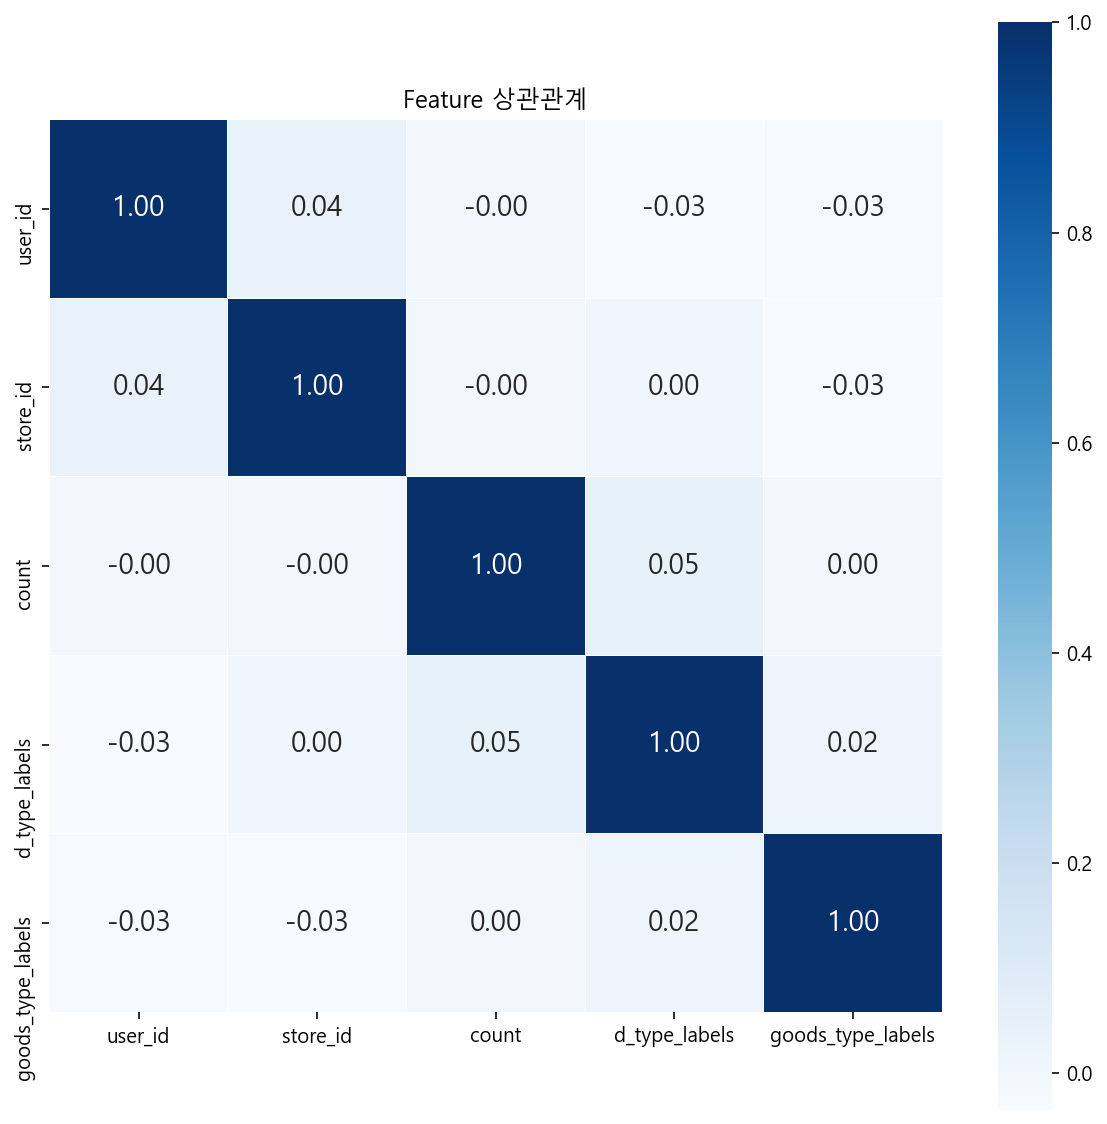

In [332]:
# 컬럼별 상관관계
plt.figure(figsize=(10, 10));
sns.heatmap(user2.corr(),
            linewidths=0.01,
            square=True,
            annot=True,
            annot_kws={'size':14},
            fmt='.2f',
            cmap='Blues')
plt.title('Feature 상관관계')

* feature간 상관관계는 0에 가까움
* 피처 간 조합 등을 통해 유의미한 새로운 feature를 생성해야 함
<br><br>
==> 상관관계 (종속변수가 정규성을 띄어야 함). COUNT 컬럼은 정규성을 보이지 않음. **그러면 당연히 상관관계를 봤을 때, 어느것도 상관관계가 있다고 나오지 않음** <br>
또한, 범주형 변수를 레이블 인코딩으로 수치화한 것을 바탕으로 상관관계를 본 것이므로 X<br>

## EDA

### 얼마나 이용했을까?

In [333]:
user2.head()

,user_id,join_date,store_id,date,count,ad1,d_type_labels,goods_type_labels
0,2858,2014-01-07,1892,2020-01-01,1,GN,0,0
1,5647,2014-02-14,182009,2020-01-01,1,J,1,0
2,33314,2014-11-20,82431,2020-01-01,1,SC,1,0
3,37001,2014-12-04,725,2020-01-01,1,MP,1,2
4,37819,2014-12-07,220691,2020-01-01,1,JRR,0,2


In [334]:
display(user.groupby('user_id')['count'].sum().reset_index().sort_values(by='count', ascending=False).head(7))
print(f'전체 기간 총 결제건수 200회 이상인 유저수:', len(user.groupby('user_id')['count'].sum().\
                                     reset_index().sort_values(by='count', ascending=False).query('count >= 200')))

,user_id,count
44115,999665,7919
100781,1514190,284
16448,591610,245
90227,1467323,239
76230,1355841,235
62809,1224426,223
82063,1407916,222


전체 기간 총 결제건수 200회 이상인 유저수: 17


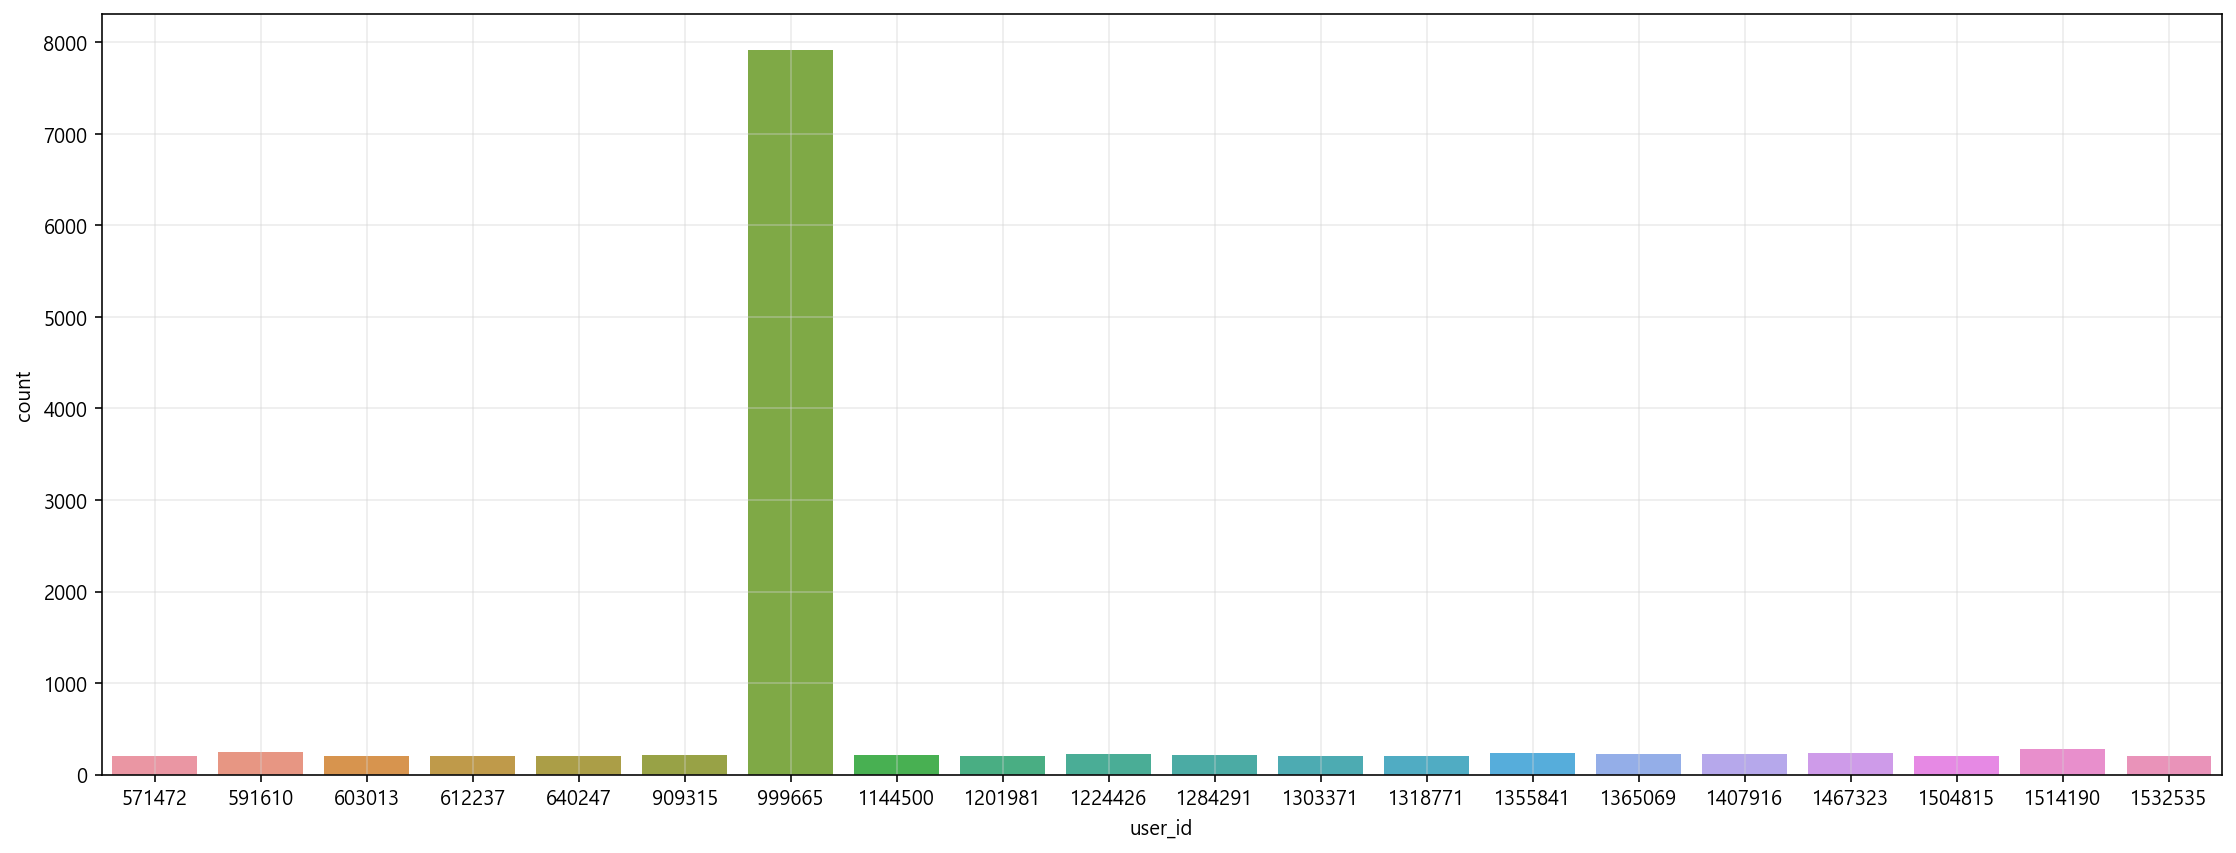

In [335]:
plt.figure(figsize=(19, 7))
sns.barplot(data=user.groupby('user_id')['count'].sum().reset_index().sort_values(by='count', ascending=False).head(20),
           x='user_id', y='count')
plt.grid(color='lightgrey', alpha=0.43)

USER ID 999665: 전체 기간 동안 7819회 구매

In [336]:
user2.query('user_id==999665').sort_values(by='count', ascending=False).head(5)

,user_id,join_date,store_id,date,count,ad1,d_type_labels,goods_type_labels
729776,999665,2018-12-16,96266,2020-11-07,61,GN,2,0
748372,999665,2018-12-16,109677,2020-11-13,59,JRR,2,0
751974,999665,2018-12-16,1109,2020-11-14,58,JRR,2,0
726277,999665,2018-12-16,190055,2020-11-06,55,SB,2,0
767392,999665,2018-12-16,131081,2020-11-19,53,YO,2,0


* 일일 결제건수 max 값 61의 범인도 user_id=999665

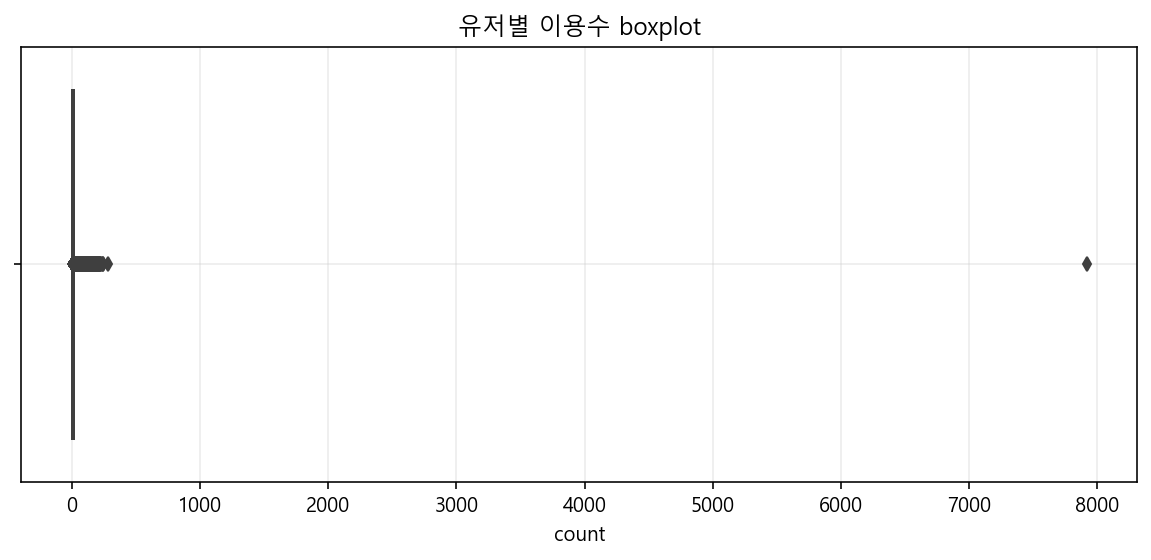

In [337]:
# 유저별 COUNT 컬럼 outlier 확인
# f.set_size_inches([20, 3])
plt.figure(figsize=(10, 4))
ax = sns.boxplot(data=user.groupby('user_id')['count'].sum().reset_index().sort_values(by='count', ascending=False),
                 x='count')
ax.set_title('유저별 이용수 boxplot')
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.grid(color='lightgrey', alpha=0.45)

* outlier(user id 999665)외에는 유저별 이용수(전체 기간)는 전부 300회 미만

**--> 이상치? 어떻게 처리할지 고민**

### 월별 이용 '횟수'

In [338]:
user3 = user2.copy()
user3['join_year'] = user3['join_date'].dt.year
user3['date_year'] = user['date'].dt.year
user3['date_month'] = user['date'].dt.month
user3['date_weekday'] = user['date'].dt.day_name()
user3.head()

,user_id,join_date,store_id,date,count,ad1,d_type_labels,goods_type_labels,join_year,date_year,date_month,date_weekday
0,2858,2014-01-07,1892,2020-01-01,1,GN,0,0,2014,2020,1,Wednesday
1,5647,2014-02-14,182009,2020-01-01,1,J,1,0,2014,2020,1,Wednesday
2,33314,2014-11-20,82431,2020-01-01,1,SC,1,0,2014,2020,1,Wednesday
3,37001,2014-12-04,725,2020-01-01,1,MP,1,2,2014,2020,1,Wednesday
4,37819,2014-12-07,220691,2020-01-01,1,JRR,0,2,2014,2020,1,Wednesday


In [340]:
# monthly_user_ = user3.groupby(['date_month'])['user_id'].count().reset_index()
# display()
# sns.lineplot()

### 월별 '이용자수' (unique value)

In [341]:
monthly_user = user3.pivot_table(index='date_month',
                                  values='user_id', 
                                  aggfunc=pd.Series.nunique)
monthly_user.reset_index(inplace=True)
monthly_user

,date_month,user_id
0,1,26410
1,2,24738
2,3,23678
3,4,27556
4,5,31393
5,6,32207
6,7,36110
7,8,33888
8,9,31296
9,10,39331


In [342]:
user3.loc[user3['date_month'] == 1, 'user_id'].nunique()

26410

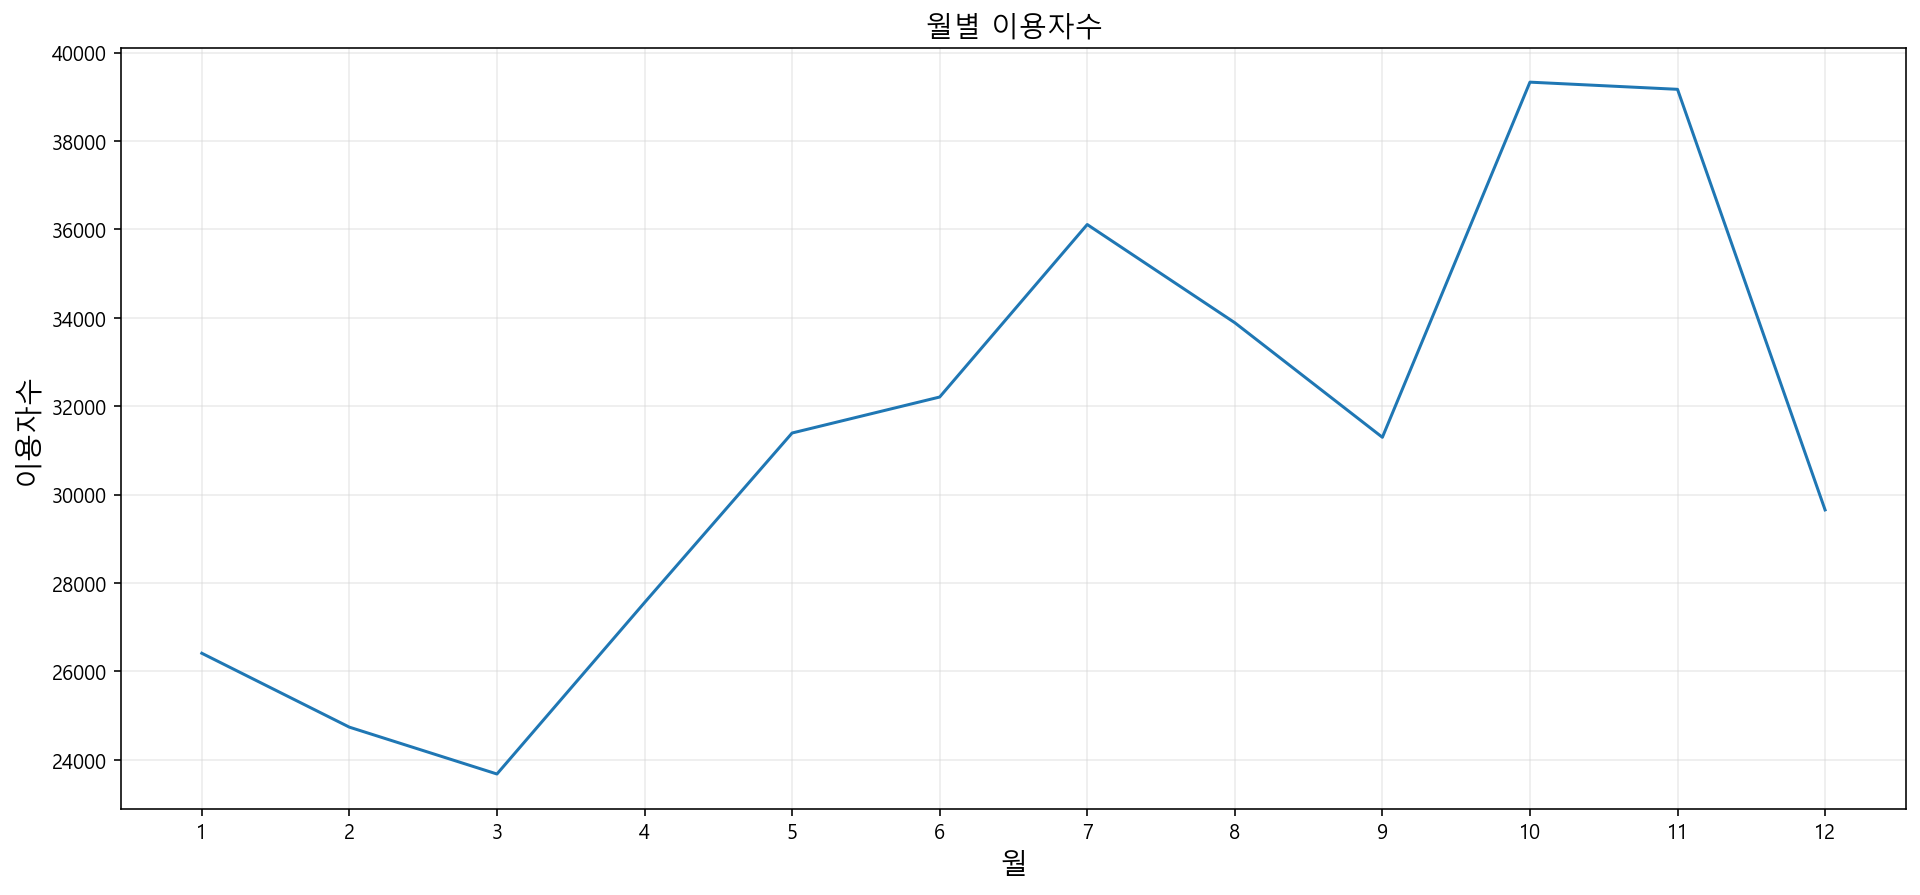

In [343]:
plt.figure(figsize=(16, 7))
sns.lineplot(data=monthly_user, x='date_month', y='user_id')
plt.xticks(np.arange(1, 13, step=1))
plt.title('월별 이용자수', fontsize=14)
plt.xlabel('월', fontsize=14)
plt.ylabel('이용자수', fontsize=14)
plt.grid(color='lightgrey', alpha=0.43)

**http://biz.newdaily.co.kr/site/data/html/2021/01/19/2021011900121.html** <br>
* 월별 이용자수(unique값): 3월이 가장 낮았고, 이후로 상승하다가 9월에 다시 좀 하락, 그리고 10월에 최고점을 찍고 다시 하락
<br>(2020년 3월, 2020년 9월)<br><br>
--> 2020년 2월, 3월 대구/경북 코로나 유행<br>
* (2월 29일 하루 신규 확진자 909명 정점) --> 1차 대유행
<br>
--> 2020년 8-9월<br>
* 8·15 광복절 도심 집회와 서울 성북구 사랑제일교회를 축으로 하는 집단감염에서 확진자가 속출했다. ‘2차 대유행(1만3282명 감염)

### 요일별 이용자수(unique)

* 요일별 이용자수 총합 추이

In [344]:
weekday_user = user3.pivot_table(index='date_weekday',
                                 values='user_id',
                                 aggfunc=pd.Series.nunique)
weekday_user.reset_index(inplace=True)
weekday_user

,date_weekday,user_id
0,Friday,58586
1,Monday,45346
2,Saturday,64406
3,Sunday,45577
4,Thursday,51843
5,Tuesday,48465
6,Wednesday,50681


In [345]:
weekday_user = weekday_user.reindex(index=[1, 5, 6, 4, 0, 2, 3])
weekday_user

,date_weekday,user_id
1,Monday,45346
5,Tuesday,48465
6,Wednesday,50681
4,Thursday,51843
0,Friday,58586
2,Saturday,64406
3,Sunday,45577


In [346]:
weekday_user.date_weekday.values.tolist()

['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

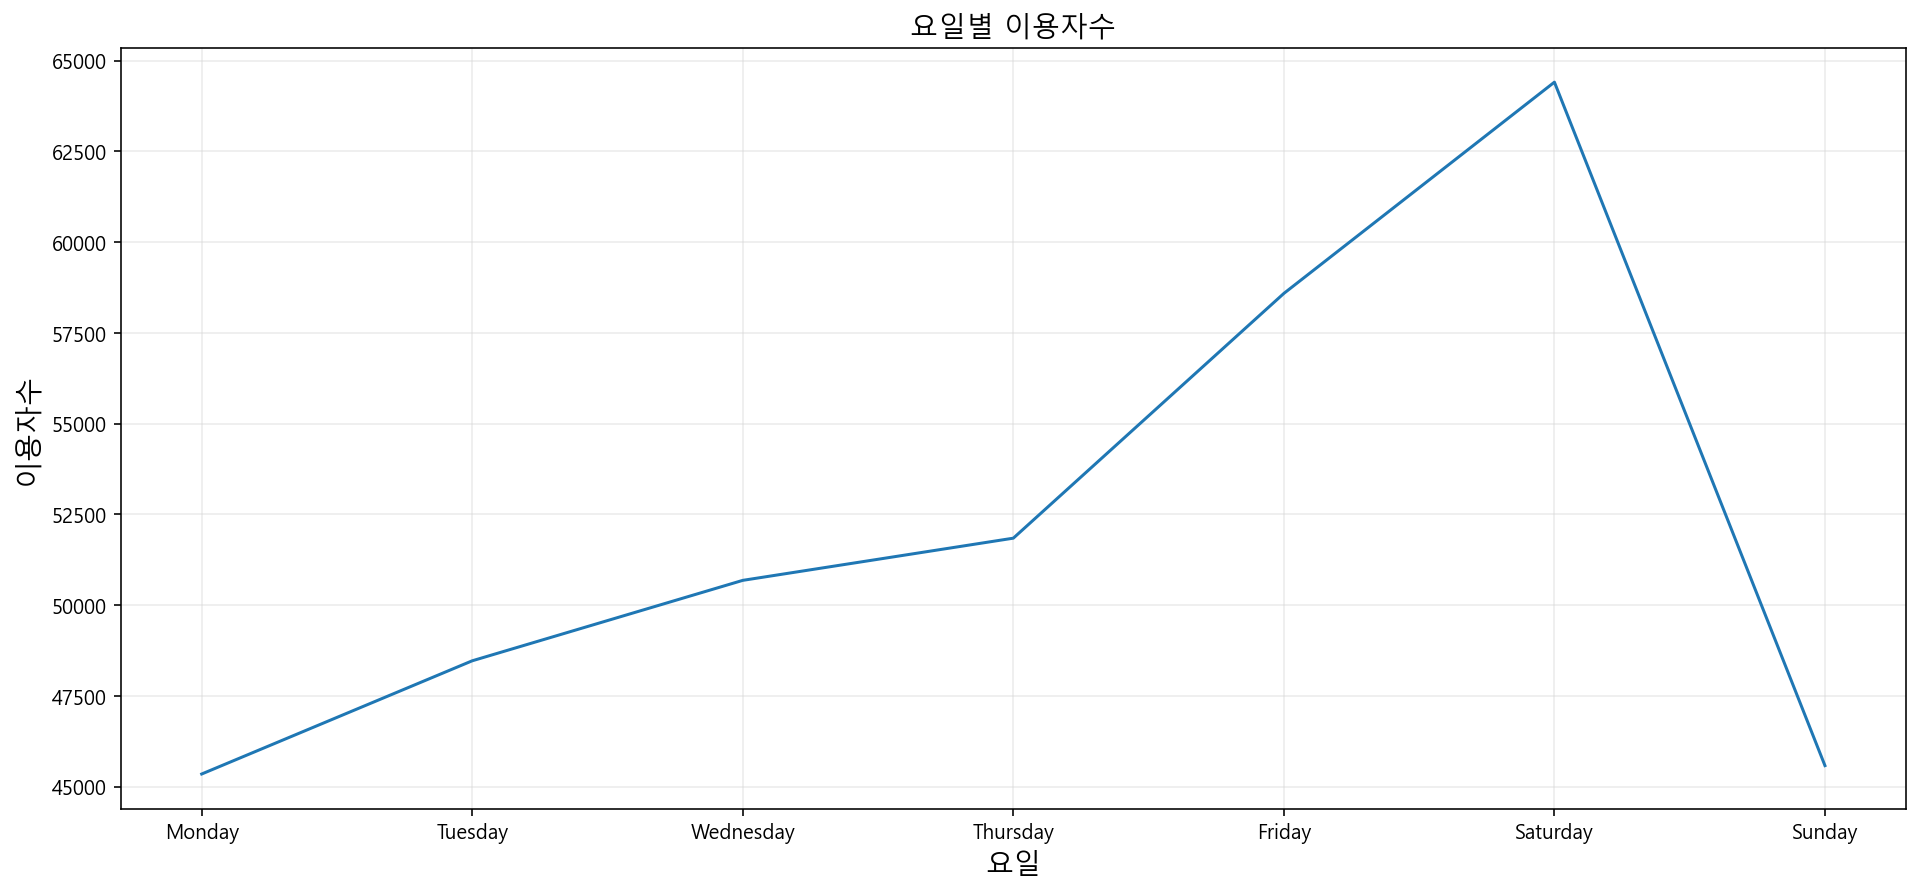

In [347]:
plt.figure(figsize=(16, 7))
sns.lineplot(data=weekday_user, x='date_weekday', y='user_id', sort=False)
plt.title('요일별 이용자수', fontsize=14)
plt.xlabel('요일', fontsize=14)
plt.ylabel('이용자수', fontsize=14)
plt.grid(color='lightgrey', alpha=0.43)

* 이용자수는 평일에 서서히 증가하다가 토요일에 정점을 찍고 일요일에 급락

In [348]:
user3.head()

,user_id,join_date,store_id,date,count,ad1,d_type_labels,goods_type_labels,join_year,date_year,date_month,date_weekday
0,2858,2014-01-07,1892,2020-01-01,1,GN,0,0,2014,2020,1,Wednesday
1,5647,2014-02-14,182009,2020-01-01,1,J,1,0,2014,2020,1,Wednesday
2,33314,2014-11-20,82431,2020-01-01,1,SC,1,0,2014,2020,1,Wednesday
3,37001,2014-12-04,725,2020-01-01,1,MP,1,2,2014,2020,1,Wednesday
4,37819,2014-12-07,220691,2020-01-01,1,JRR,0,2,2014,2020,1,Wednesday


In [349]:
d = user3.pivot_table(index=['date_month', 'date_weekday'],
                                     values='user_id', 
                                     aggfunc=pd.Series.nunique).reset_index()
d.head()

,date_month,date_weekday,user_id
0,1,Friday,7198
1,1,Monday,4684
2,1,Saturday,6730
3,1,Sunday,5028
4,1,Thursday,6248


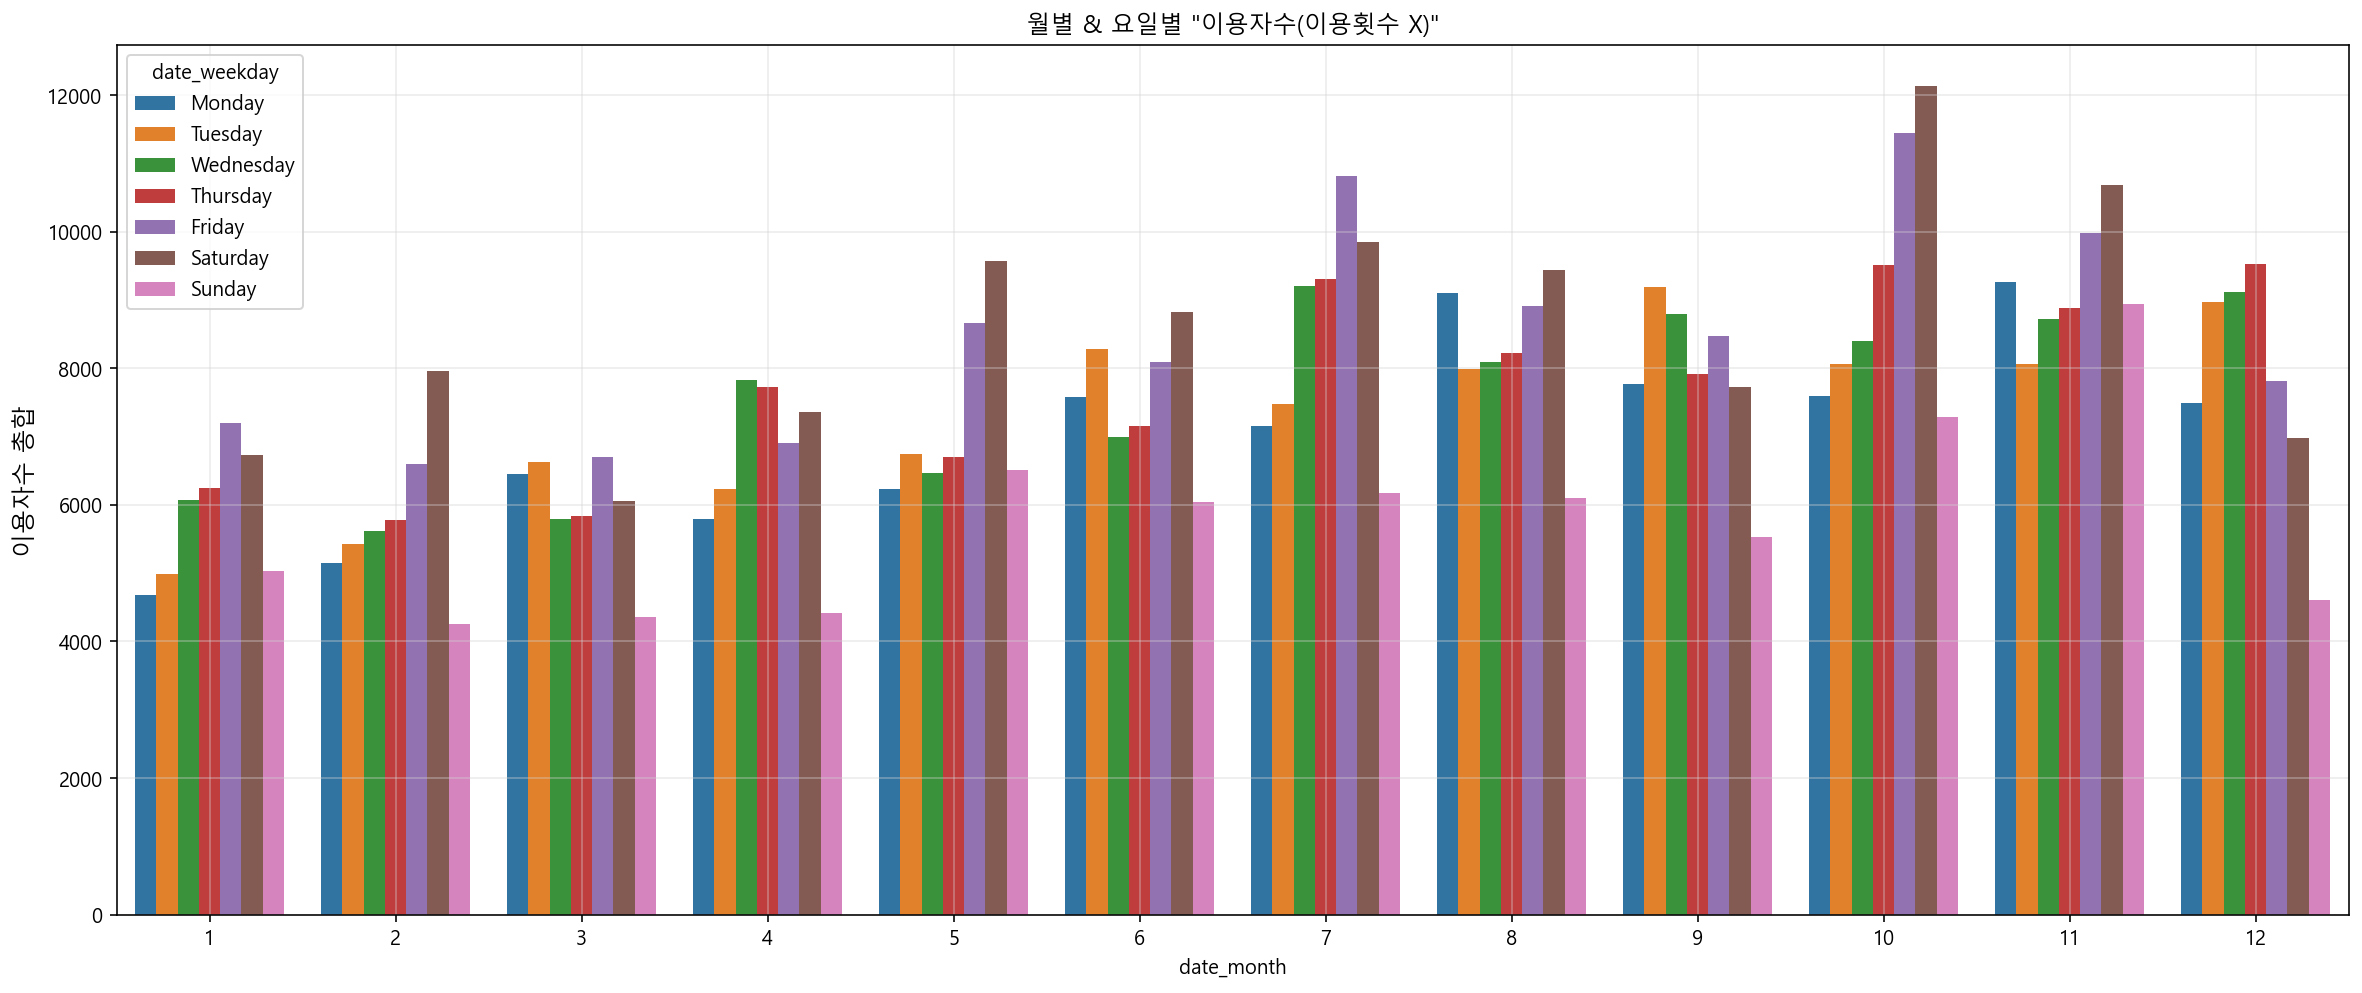

In [350]:
plt.figure(figsize=(20,8))
sns.barplot(data=d, x='date_month', y='user_id', hue='date_weekday', hue_order=['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                                                                                'Friday', 'Saturday', 'Sunday'])
plt.title('월별 & 요일별 "이용자수(이용횟수 X)"', fontsize=12)
plt.ylabel('이용자수 총합', fontsize=12)
plt.grid(color='lightgrey', alpha=0.43)

### d_type & goods_type

In [351]:
user3.head()

,user_id,join_date,store_id,date,count,ad1,d_type_labels,goods_type_labels,join_year,date_year,date_month,date_weekday
0,2858,2014-01-07,1892,2020-01-01,1,GN,0,0,2014,2020,1,Wednesday
1,5647,2014-02-14,182009,2020-01-01,1,J,1,0,2014,2020,1,Wednesday
2,33314,2014-11-20,82431,2020-01-01,1,SC,1,0,2014,2020,1,Wednesday
3,37001,2014-12-04,725,2020-01-01,1,MP,1,2,2014,2020,1,Wednesday
4,37819,2014-12-07,220691,2020-01-01,1,JRR,0,2,2014,2020,1,Wednesday


,d_type_labels
0,0.560881
1,0.437341
2,0.001779


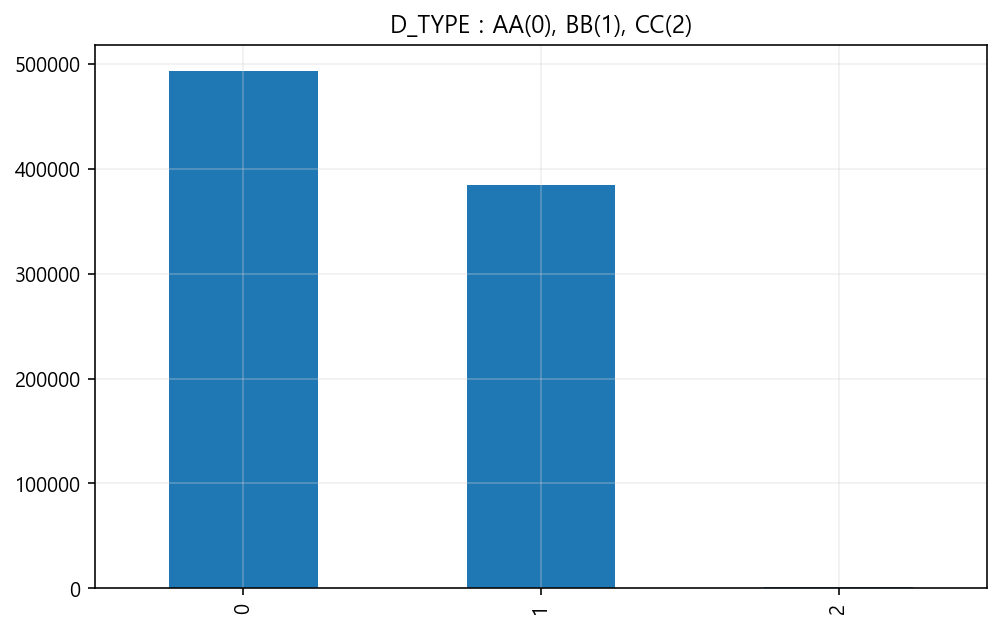

In [352]:
user3['d_type_labels'].value_counts().plot(kind='bar', figsize=(8, 5))
display(user3['d_type_labels'].value_counts(normalize=True).to_frame().style.background_gradient(cmap='gray_r'))
plt.title('D_TYPE : AA(0), BB(1), CC(2)')
plt.grid(color='lightgrey', alpha=0.34)

* D_TYPE의 AA가 56%
* D_TYPE의 BB가 44%
* D_TYPE의 CC가 0.2%

,goods_type_labels
0,0.693518
2,0.149172
1,0.134817
3,0.022492


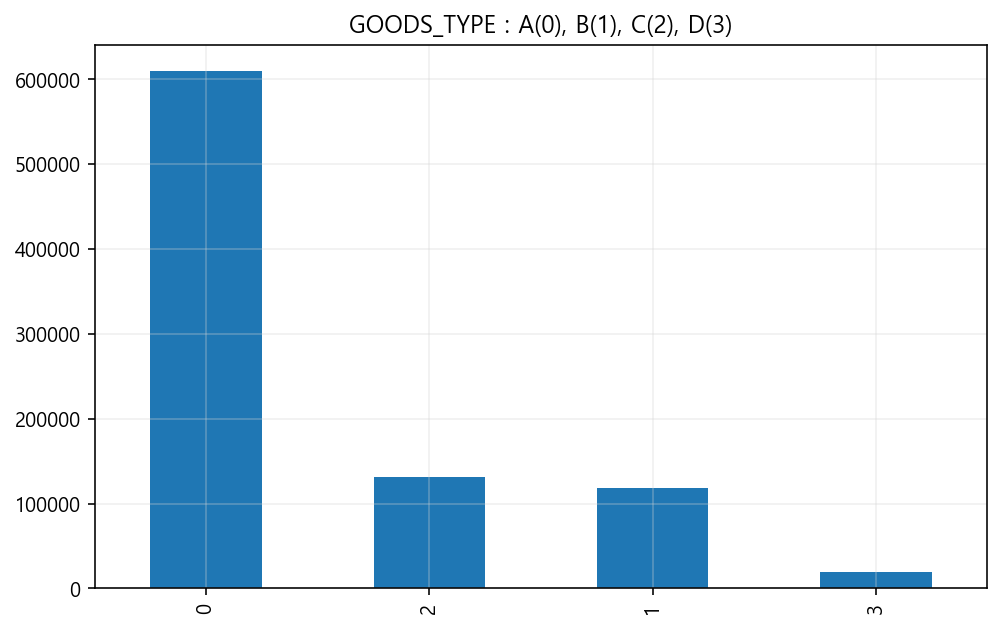

In [353]:
user3['goods_type_labels'].value_counts().plot(kind='bar', figsize=(8, 5))
display(user3['goods_type_labels'].value_counts(normalize=True).to_frame().style.background_gradient(cmap='gray_r'))
plt.title('GOODS_TYPE : A(0), B(1), C(2), D(3)')
plt.grid(color='lightgrey', alpha=0.34)

* GOODS_TYPE의 A가 69%
* GOODS_TYPE의 B가 15%
* GOODS_TYPE의 C가 13%
* GOODS_TYPE의 D가 2%

### store_id

In [354]:
user3.head()

,user_id,join_date,store_id,date,count,ad1,d_type_labels,goods_type_labels,join_year,date_year,date_month,date_weekday
0,2858,2014-01-07,1892,2020-01-01,1,GN,0,0,2014,2020,1,Wednesday
1,5647,2014-02-14,182009,2020-01-01,1,J,1,0,2014,2020,1,Wednesday
2,33314,2014-11-20,82431,2020-01-01,1,SC,1,0,2014,2020,1,Wednesday
3,37001,2014-12-04,725,2020-01-01,1,MP,1,2,2014,2020,1,Wednesday
4,37819,2014-12-07,220691,2020-01-01,1,JRR,0,2,2014,2020,1,Wednesday


store_id unique 개수: 1061개


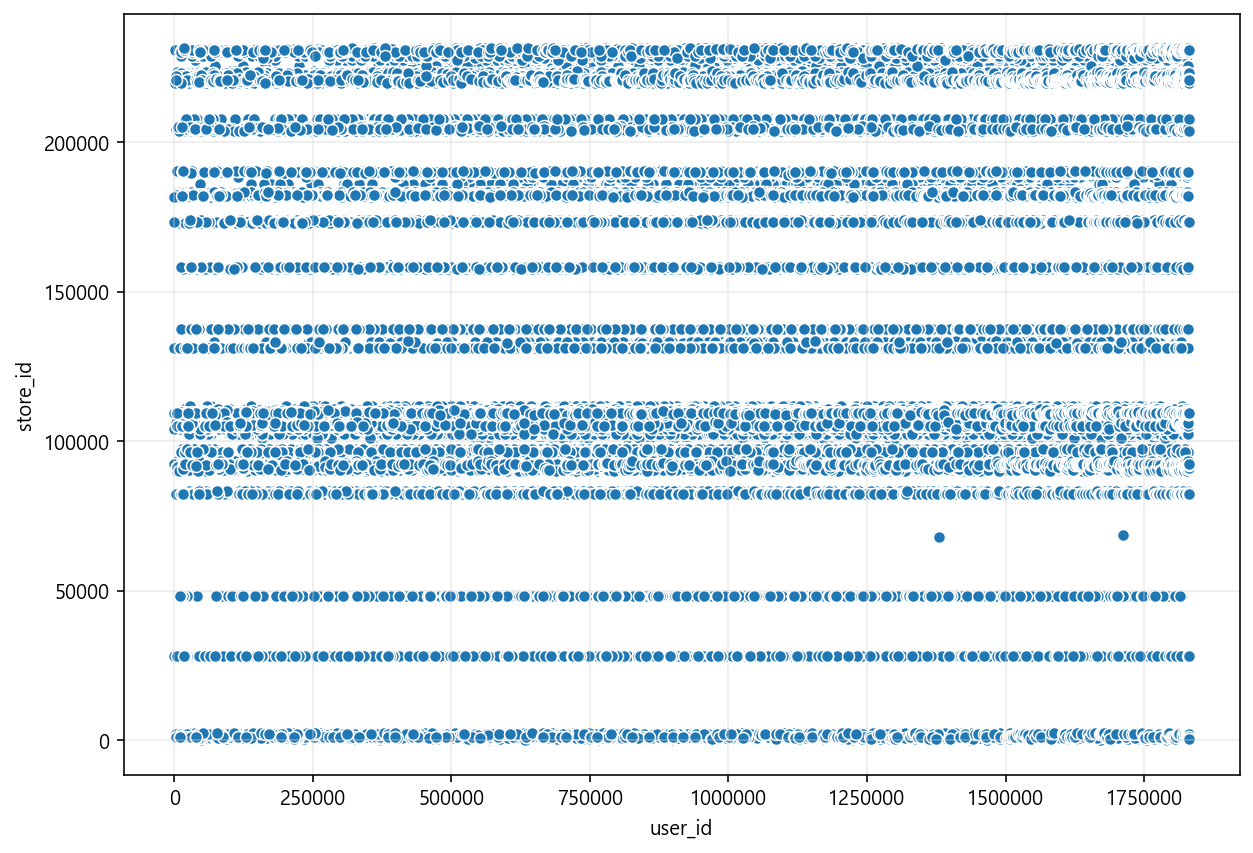

In [355]:
print(f'store_id unique 개수: {user3.store_id.nunique()}개')
plt.figure(figsize=(10, 7))
ax = sns.scatterplot(data=user3, x='user_id', y='store_id')
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.grid(color='lightgrey', alpha=0.43)

In [356]:
user3.store_id.value_counts().head()

220557    17617
220893    17220
220655    16275
220848    15935
92437     15866
Name: store_id, dtype: int64

### ad1

ad1 unique 개수: 85개


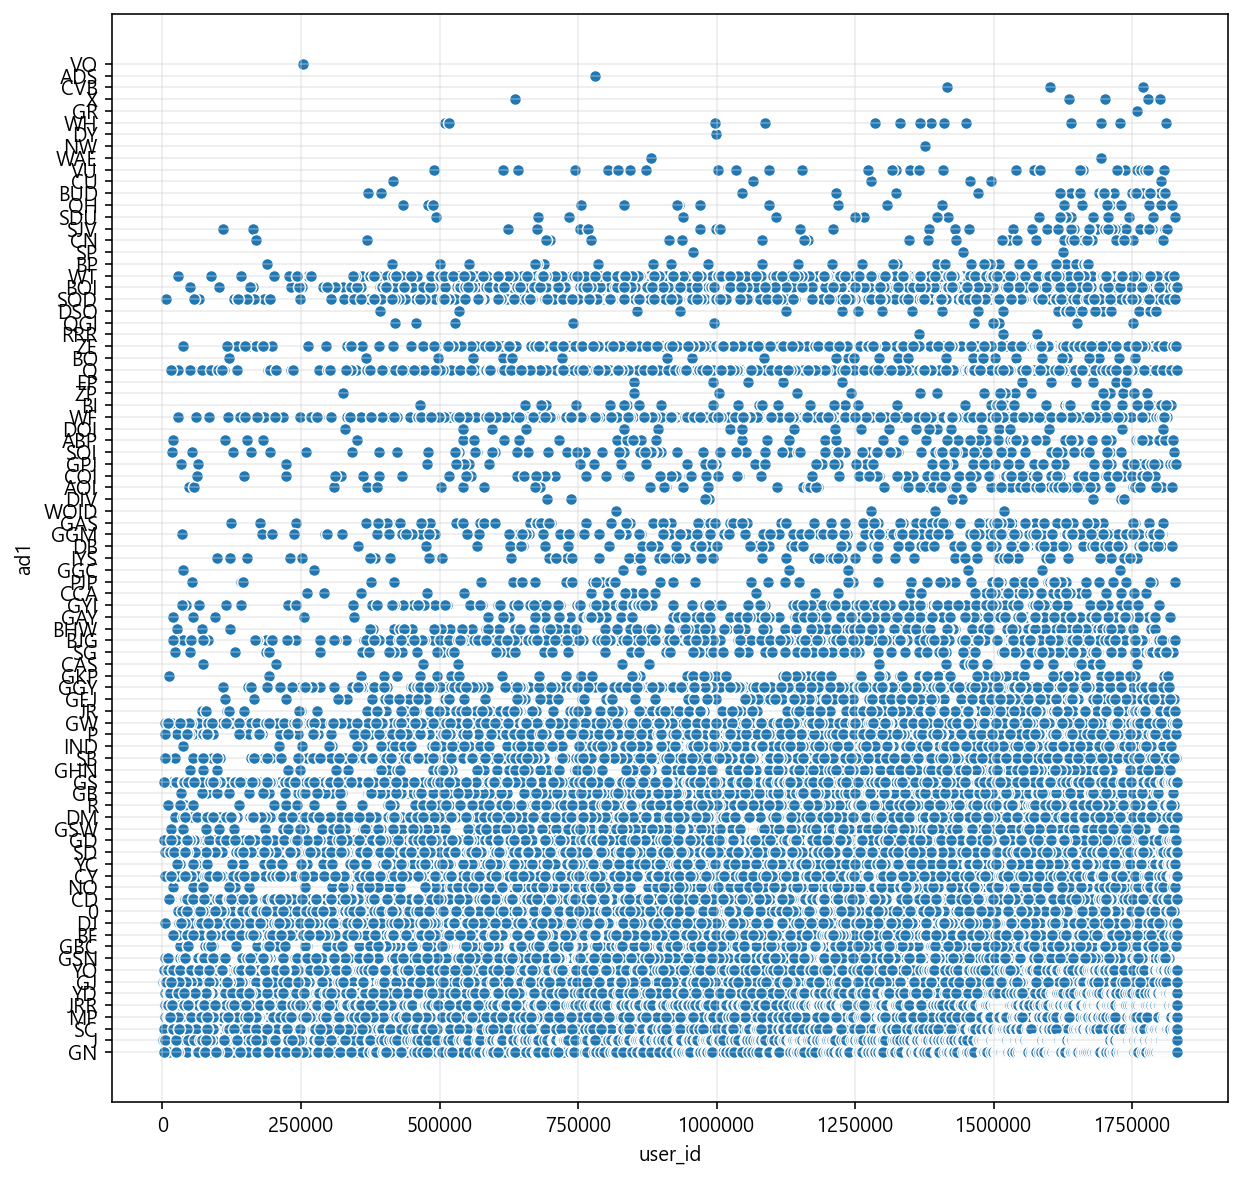

In [357]:
print(f'ad1 unique 개수: {user3.ad1.nunique()}개')
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(data=user3, x='user_id', y='ad1')
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.grid(color='lightgrey', alpha=0.43)

* user_id와 ad1 간에 별다른 규칙성 찾지 못했음

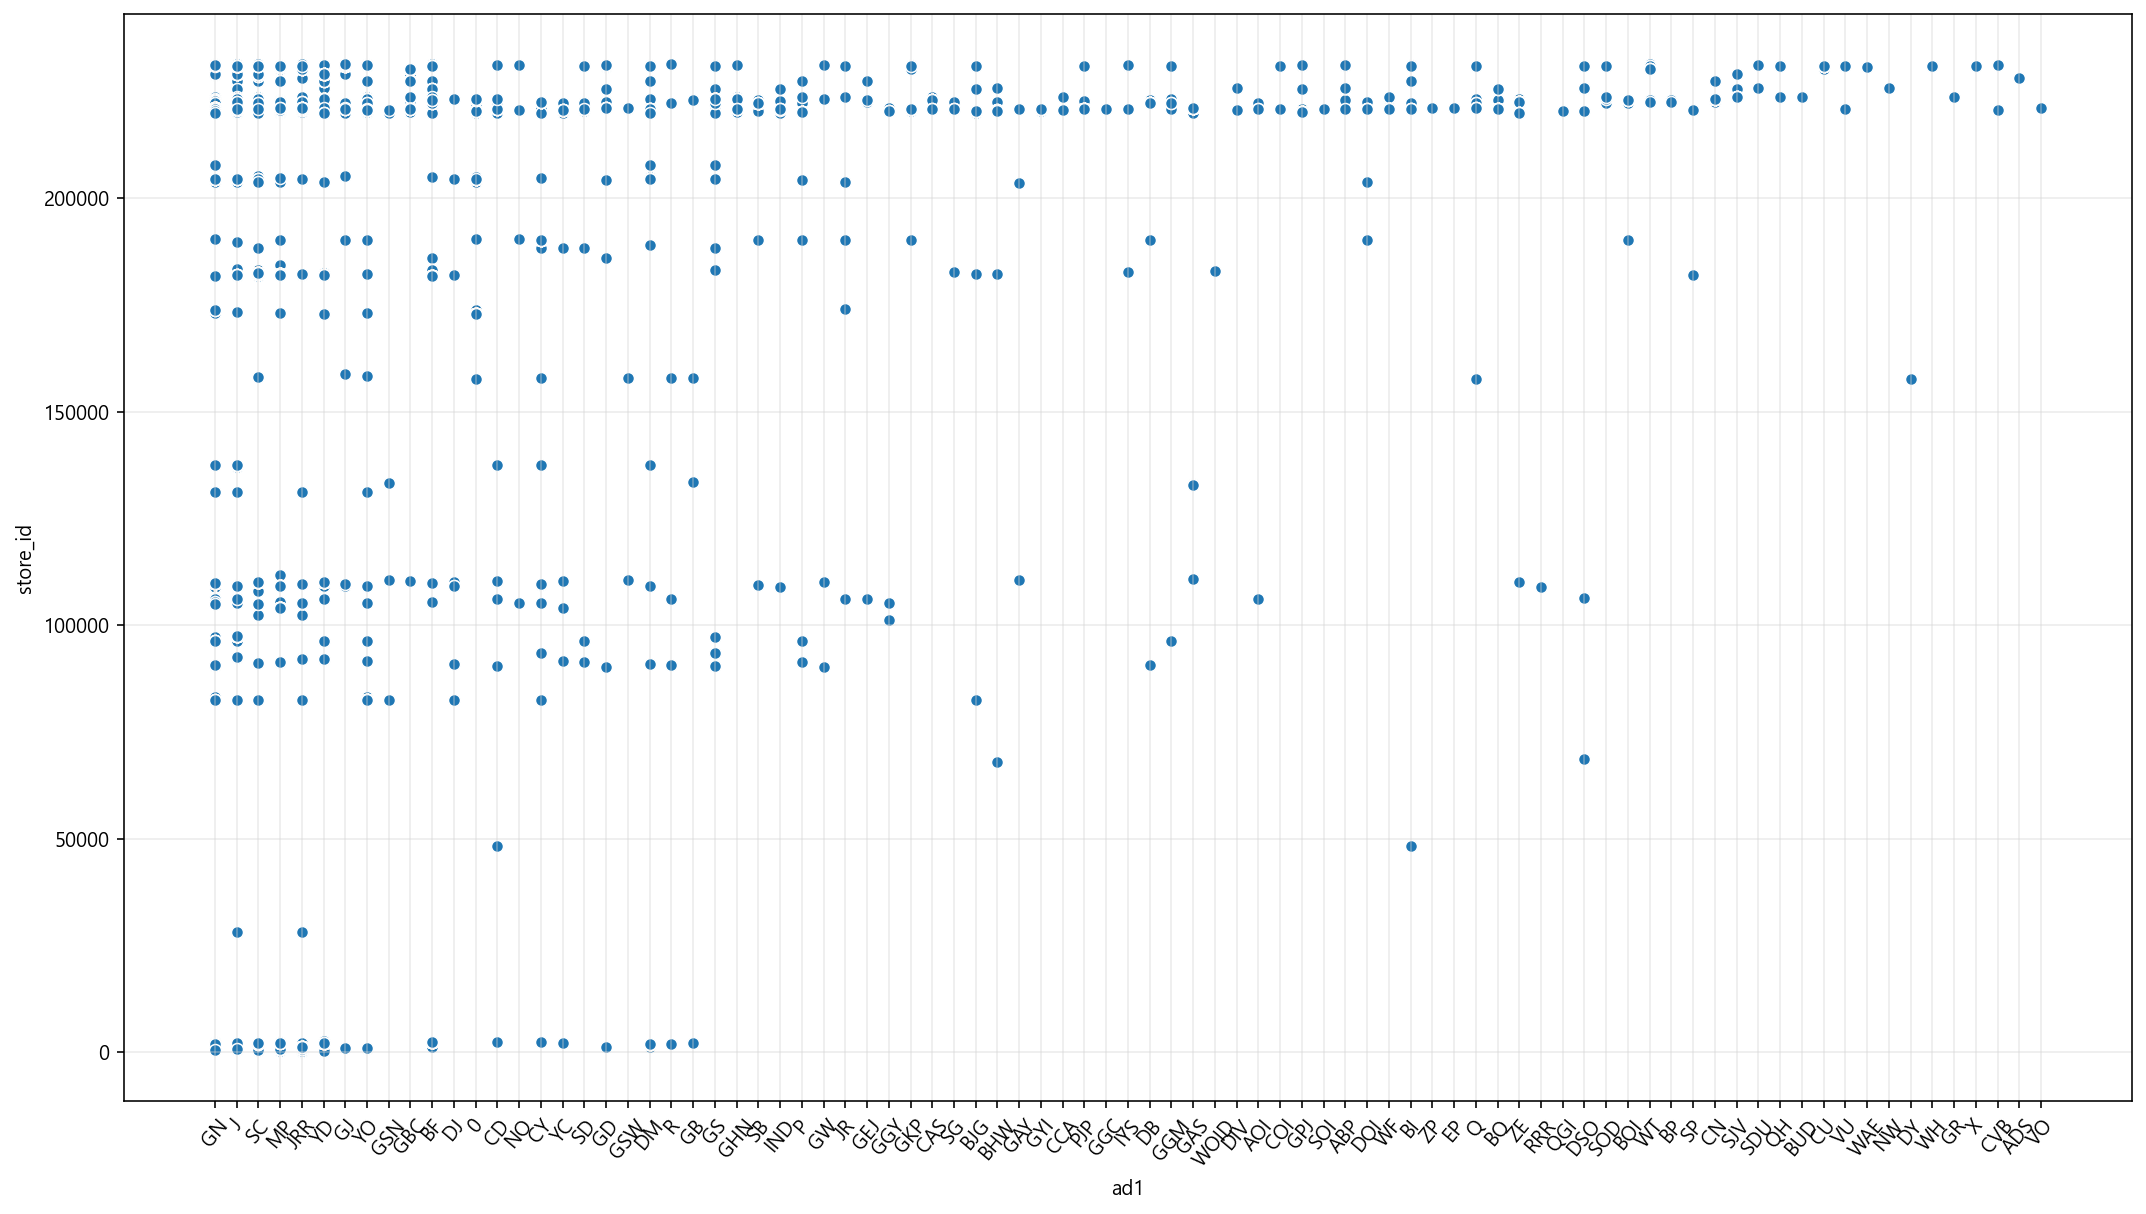

In [358]:
plt.figure(figsize=(18, 10))
sns.scatterplot(data=user3, x='ad1', y='store_id')
plt.xticks(rotation=50)
plt.grid(color='lightgrey', alpha=0.43)

### 종속변수 'COUNT'

In [359]:
print(user3['count'].nunique())

56


,count
1,0.982376
2,0.015375
3,0.001207
4,0.000308
5,0.000155


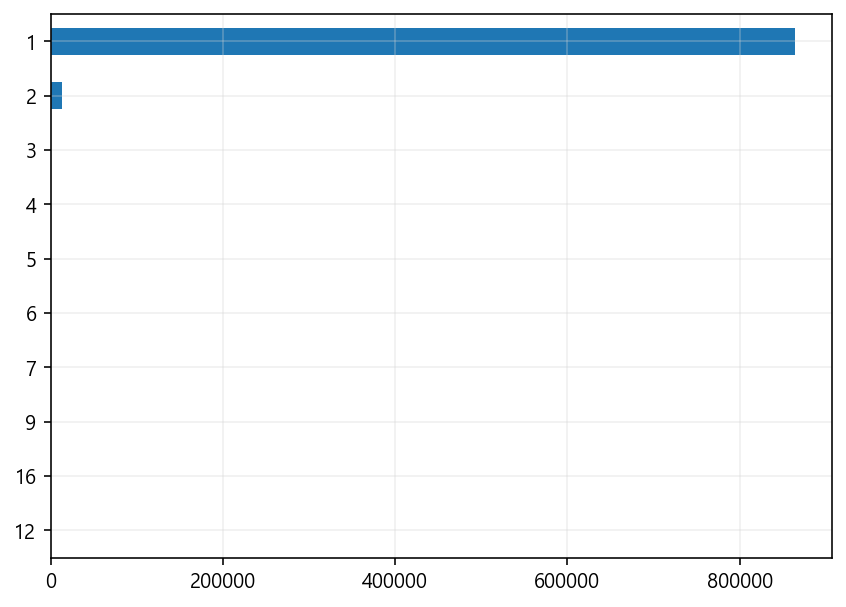

In [360]:
display(user3['count'].value_counts(normalize=True).to_frame().head(5).style.background_gradient(cmap='gray_r'))
user3['count'].value_counts().head(10).sort_values(ascending=True).plot.barh(figsize=(7, 5))
plt.grid(color='lightgrey', alpha=0.34)

<AxesSubplot:ylabel='Density'>

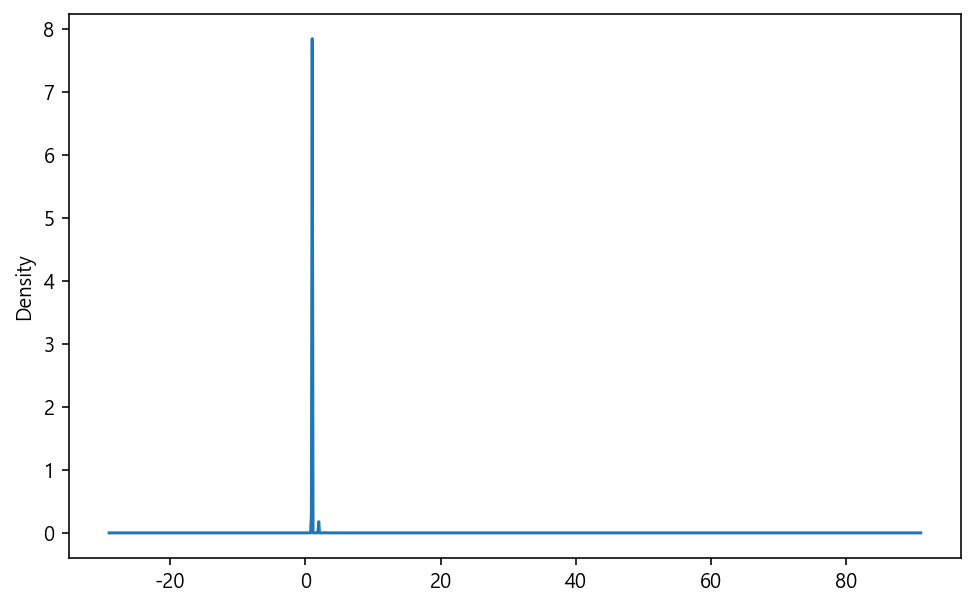

In [361]:
user3['count'].plot(kind='kde', figsize=(8, 5))

* 일일 이용횟수(count 컬럼)가 1인 게 너무 많음(98%)
* 이걸 다 지울수는 없음(데이터 훼손 너무 커질 우려)

# 2차 EDA 및 feature engineering

## 전처리 조건
* **이상치 처리**
     - 7800건 넘게 결제한 사람은 제거
     - join_date이 1970-01-01인 데이터 --> join_date 컬럼 정보를 사용한다면 해당 데이터 제거
<br><br>

* **예측 모델**
     - 현제 데이터의 종속변수가 한쪽으로 치우쳐져 있어 상관관계를 보는게 의미가 없다.
     - 데이터 셋의 변수가 대부분 범주형이므로 랜덤포레스트를 사용(혹은 다른 regressor)
     - 범주형 변수는 원핫인코딩/라벨인코딩 중 하나
<br><br>
* **동의된 feature**
    - Weekdays/holiday
    - d_type
    - store_id
    - AD1
    - retention
    - join_date
    - 교통량
    - 강수량
    - 기온(최고/최저)
    - 적설량
    - goods_type
<br><br>
* **문자형 --> Label encoding**

In [373]:
# join_date가 1970-01-01인 데이터 제거
user4 = user3.copy()
user4.drop(index=user4.loc[user4['join_date']=='1970-01-01'].index, inplace=True)    
user4.shape

(878178, 12)

In [374]:
# 7800건 넘게 결제한 사람 제거 (user_id : 999665)
user4.drop(index=user4.loc[user4['user_id'] == 999665].index, inplace=True)
user4.shape

(877812, 12)

In [375]:
# ad1 --> Label encoding
LE = LabelEncoder()
LE.fit(user4['ad1'])
LE_labels = LE.transform(user4['ad1'])
user4['ad2'] = LE_labels
display(user4.head())
print(f'ad1 인코딩 클래스: {LE.classes_}')

,user_id,join_date,store_id,date,count,ad1,d_type_labels,goods_type_labels,join_year,date_year,date_month,date_weekday,ad2
0,2858,2014-01-07,1892,2020-01-01,1,GN,0,0,2014,2020,1,Wednesday,39
1,5647,2014-02-14,182009,2020-01-01,1,J,1,0,2014,2020,1,Wednesday,49
2,33314,2014-11-20,82431,2020-01-01,1,SC,1,0,2014,2020,1,Wednesday,63
3,37001,2014-12-04,725,2020-01-01,1,MP,1,2,2014,2020,1,Wednesday,52
4,37819,2014-12-07,220691,2020-01-01,1,JRR,0,2,2014,2020,1,Wednesday,51


ad1 인코딩 클래스: ['0' 'ABP' 'ADS' 'AOI' 'BF' 'BHW' 'BI' 'BJG' 'BO' 'BOI' 'BP' 'BUD' 'CAS'
 'CCA' 'CD' 'CN' 'COI' 'CU' 'CVB' 'CY' 'DB' 'DIV' 'DJ' 'DM' 'DOI' 'DSO'
 'EP' 'GAS' 'GAY' 'GB' 'GBC' 'GD' 'GEJ' 'GGC' 'GGM' 'GGY' 'GHN' 'GJ' 'GKP'
 'GN' 'GPJ' 'GR' 'GS' 'GSN' 'GSW' 'GW' 'GYI' 'IND' 'IYS' 'J' 'JR' 'JRR'
 'MP' 'NO' 'NW' 'P' 'PJP' 'Q' 'QGI' 'QH' 'R' 'RRR' 'SB' 'SC' 'SD' 'SDU'
 'SG' 'SJV' 'SOD' 'SOI' 'SP' 'VO' 'VU' 'WAE' 'WF' 'WH' 'WOID' 'WT' 'X'
 'YC' 'YD' 'YO' 'ZE' 'ZP']


In [379]:
display(user4['ad2'].value_counts().head())
display(user4['ad1'].value_counts().head())

49    179135
39    172721
51    126441
63     75702
52     67679
Name: ad2, dtype: int64

J      179135
GN     172721
JRR    126441
SC      75702
MP      67679
Name: ad1, dtype: int64

In [381]:
# 기존 ad1 제거
user4.drop(columns='ad1', inplace=True)
user4.head(2)

,user_id,join_date,store_id,date,count,d_type_labels,goods_type_labels,join_year,date_year,date_month,date_weekday,ad2
0,2858,2014-01-07,1892,2020-01-01,1,0,0,2014,2020,1,Wednesday,39
1,5647,2014-02-14,182009,2020-01-01,1,1,0,2014,2020,1,Wednesday,49


In [378]:
Weekdays/holiday
d_type
store_id
AD1
retention
join_date
교통량
강수량
기온(최고/최저)
적설량
goods_type

J      179135
GN     172721
JRR    126441
SC      75702
MP      67679
Name: ad1, dtype: int64

In [380]:
user4.head(2)

,user_id,join_date,store_id,date,count,ad1,d_type_labels,goods_type_labels,join_year,date_year,date_month,date_weekday,ad2
0,2858,2014-01-07,1892,2020-01-01,1,GN,0,0,2014,2020,1,Wednesday,39
1,5647,2014-02-14,182009,2020-01-01,1,J,1,0,2014,2020,1,Wednesday,49


## holiday master dataset load

In [382]:
hol = pd.read_excel('./holiday_master.xlsx')
print(hol.shape)
hol.head()

(366, 3)


,date,isholiday,exp
0,2020-01-01,holiday,새해
1,2020-01-02,weekdays,NaN
2,2020-01-03,weekdays,NaN
3,2020-01-04,weekdays,NaN
4,2020-01-05,weekdays,NaN


In [384]:
# user4의 Date 컬럼과 merge
# 둘 다 2020년 전체 기간 데이터이므로 inner merge해도 무방
user5 = user4.merge(hol, how='inner', on='date')
user5.head()

,user_id,join_date,store_id,date,count,d_type_labels,goods_type_labels,join_year,date_year,date_month,date_weekday,ad2,isholiday,exp
0,2858,2014-01-07,1892,2020-01-01,1,0,0,2014,2020,1,Wednesday,39,holiday,새해
1,5647,2014-02-14,182009,2020-01-01,1,1,0,2014,2020,1,Wednesday,49,holiday,새해
2,33314,2014-11-20,82431,2020-01-01,1,1,0,2014,2020,1,Wednesday,63,holiday,새해
3,37001,2014-12-04,725,2020-01-01,1,1,2,2014,2020,1,Wednesday,52,holiday,새해
4,37819,2014-12-07,220691,2020-01-01,1,0,2,2014,2020,1,Wednesday,51,holiday,새해


* holiday 데이터 merge한 데이터셋 **user5** 생성

<AxesSubplot:title={'center':'weekdays & holiday 비중'}>

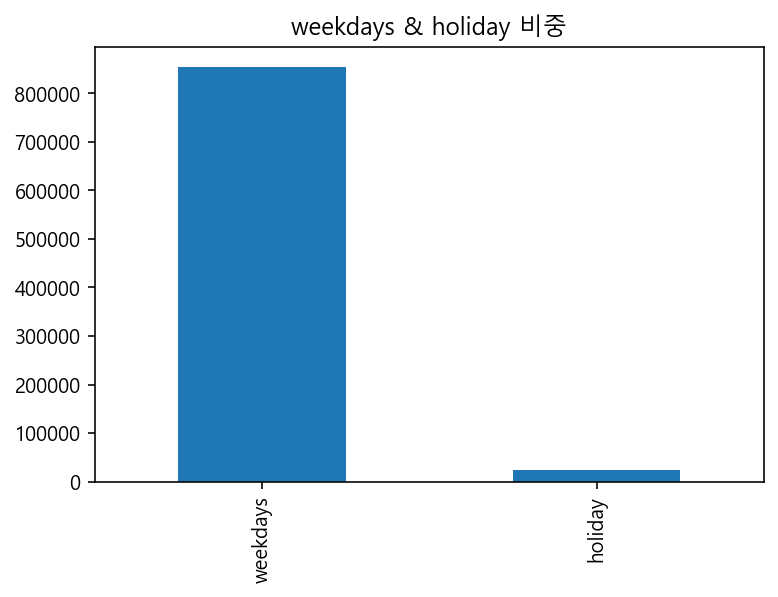

In [388]:
user5['isholiday'].value_counts().plot(kind='bar', title='weekdays & holiday 비중')

In [393]:
# 휴일과 그렇지 않은 날 중 언제 이용이 많을까?

# 이용건수 총합
display(user5.groupby(['isholiday'])['count'].sum().to_frame())

# 이용건수 평균
display(user5.groupby(['isholiday'])['count'].mean().to_frame())

,count
isholiday,
holiday,24970
weekdays,870831


,count
isholiday,
holiday,1.02
weekdays,1.02


,date_month,isholiday,count
0,1,holiday,3543
1,1,weekdays,50205
2,2,weekdays,56874
3,3,holiday,870
4,3,weekdays,62230


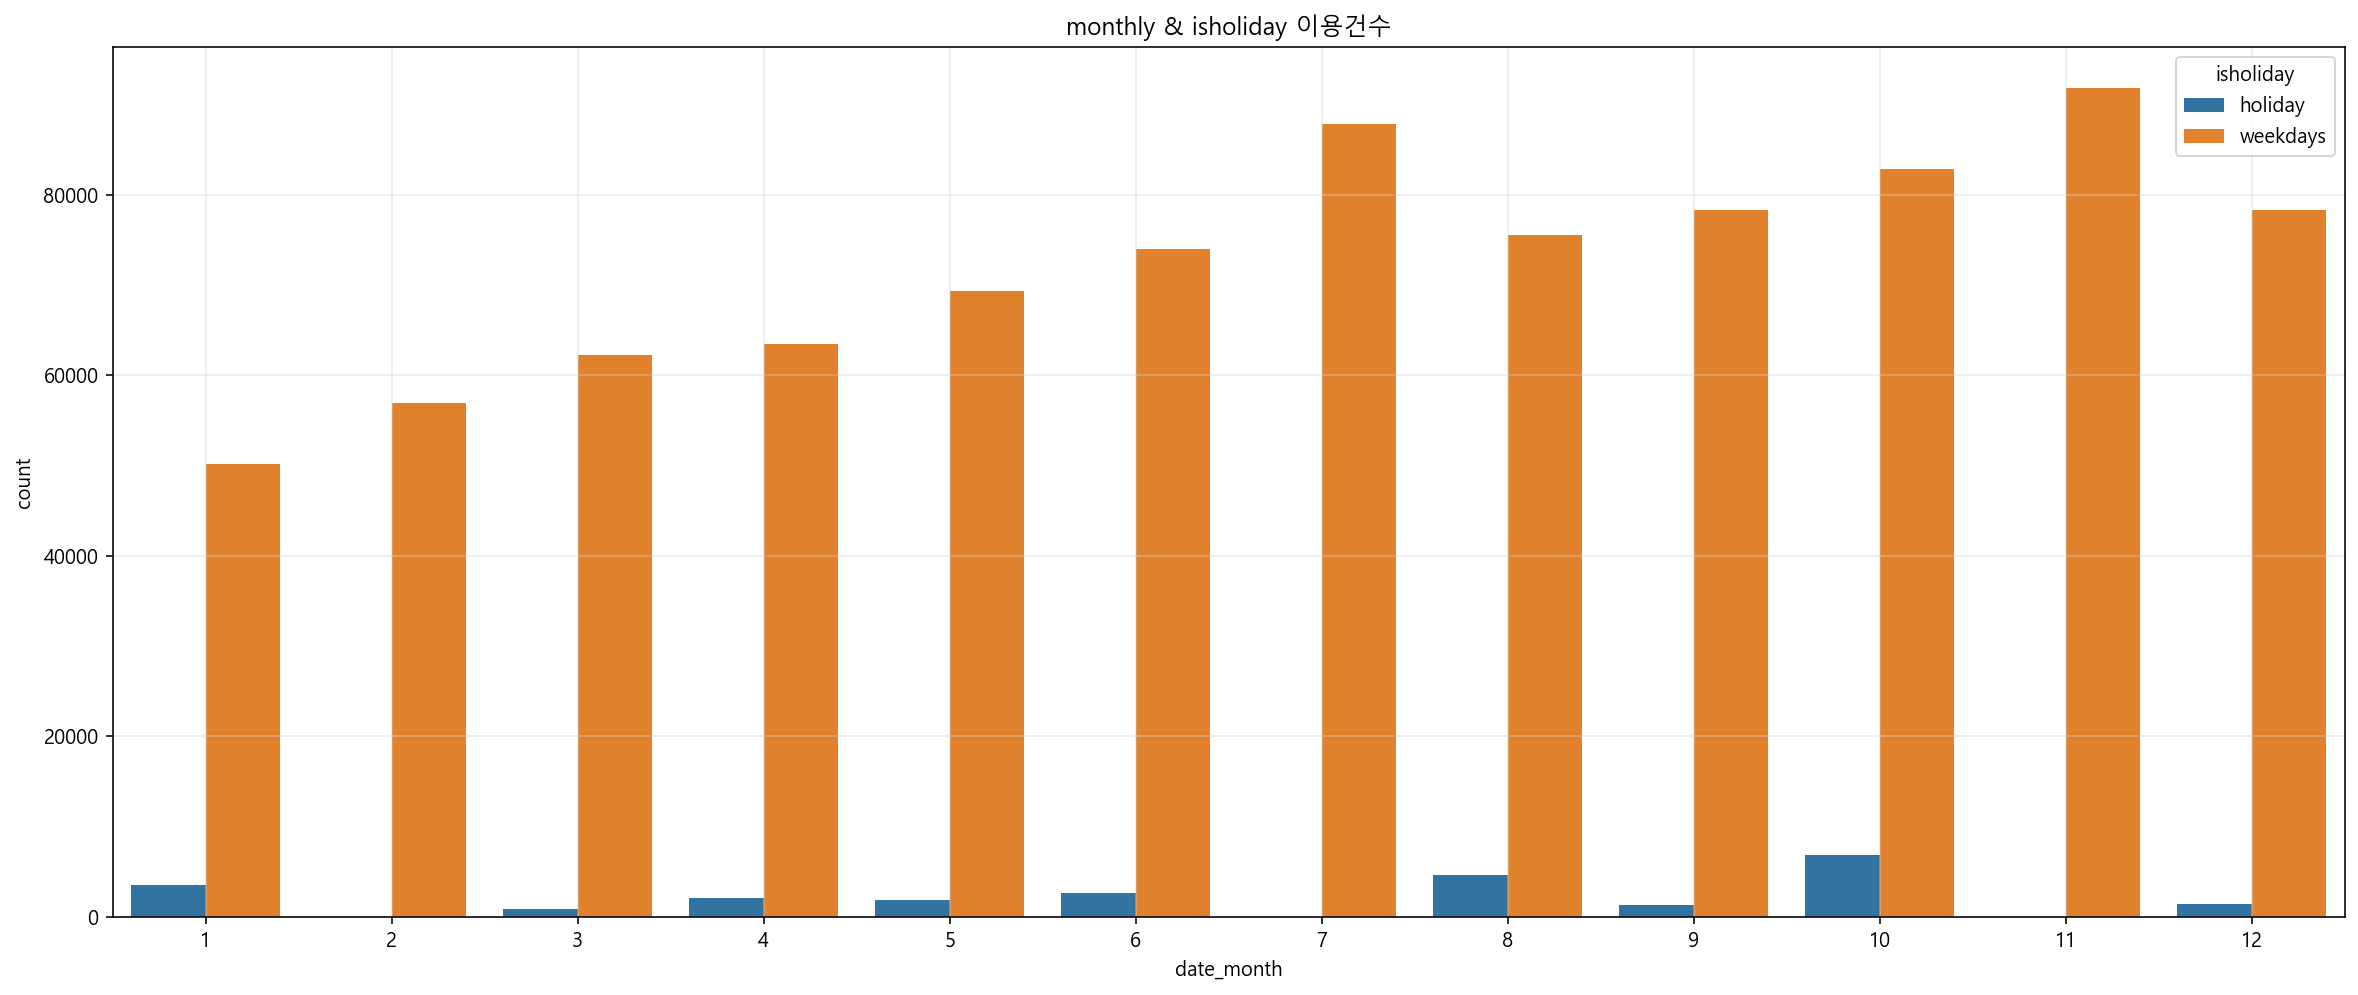

In [403]:
# 월별
monthly_isholiday = user5.groupby(['date_month', 'isholiday'])['count'].sum().reset_index()
display(monthly_isholiday.head())

plt.figure(figsize=(20, 8))
sns.barplot(data=monthly_isholiday, x='date_month', y='count', hue='isholiday')
plt.title('monthly & isholiday 이용건수', fontsize=12)
plt.grid(color='lightgrey', alpha=0.43)

* 모든 달에서 weekdays 이용건수가 압도적으로 높음(매달 holiday가 많지 않기 때문)
* holiday가 없는 달도 존재함. 공휴일이 없는 달도 있을 것
* **불균형이 심각한 컬럼 --> 활용해도 되나? --> 일단 isholiday를 제거한 데이터셋 생성(user5_noholiday)하고 모델링 후 결과 비교**

In [404]:
user5_noholiday = user5.copy()
user5_noholiday.drop(columns=['isholiday', 'exp'], inplace=True)
user5_noholiday.head(2)

,user_id,join_date,store_id,date,count,d_type_labels,goods_type_labels,join_year,date_year,date_month,date_weekday,ad2
0,2858,2014-01-07,1892,2020-01-01,1,0,0,2014,2020,1,Wednesday,39
1,5647,2014-02-14,182009,2020-01-01,1,1,0,2014,2020,1,Wednesday,49


## 기상데이터 전처리 및 EDA

In [480]:
weather.head()

,지점,일시,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도,date
0,108,2020-01-01 01:00:00,-5.90,NaN,1.70,40,NaN,NaN,-2.40,3.20,2020-01-01
1,108,2020-01-01 02:00:00,-5.70,NaN,0.10,42,NaN,NaN,-2.40,3.10,2020-01-01
2,108,2020-01-01 03:00:00,-5.60,0.00,0.00,46,NaN,NaN,-2.70,3.10,2020-01-01
3,108,2020-01-01 04:00:00,-5.40,NaN,0.00,50,NaN,NaN,-2.50,3.00,2020-01-01
4,108,2020-01-01 05:00:00,-5.20,NaN,0.00,55,NaN,NaN,-2.20,3.00,2020-01-01


In [481]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   지점      8760 non-null   int64         
 1   일시      8760 non-null   datetime64[ns]
 2   기온      8759 non-null   float64       
 3   강수량     1059 non-null   float64       
 4   풍속      8760 non-null   float64       
 5   습도      8760 non-null   int64         
 6   일조시간    4791 non-null   float64       
 7   적설량     208 non-null    float64       
 8   지면온도    8752 non-null   float64       
 9   지중온도    8748 non-null   float64       
 10  date    8760 non-null   object        
dtypes: datetime64[ns](1), float64(7), int64(2), object(1)
memory usage: 752.9+ KB


In [482]:
# 일시 --> 날짜 타입으로 변경
weather['일시'] = pd.to_datetime(weather['일시'])
weather.head()

,지점,일시,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도,date
0,108,2020-01-01 01:00:00,-5.90,NaN,1.70,40,NaN,NaN,-2.40,3.20,2020-01-01
1,108,2020-01-01 02:00:00,-5.70,NaN,0.10,42,NaN,NaN,-2.40,3.10,2020-01-01
2,108,2020-01-01 03:00:00,-5.60,0.00,0.00,46,NaN,NaN,-2.70,3.10,2020-01-01
3,108,2020-01-01 04:00:00,-5.40,NaN,0.00,50,NaN,NaN,-2.50,3.00,2020-01-01
4,108,2020-01-01 05:00:00,-5.20,NaN,0.00,55,NaN,NaN,-2.20,3.00,2020-01-01


### 일별 최고기온 & 최저기온

In [413]:
weather['date'] = weather['일시'].dt.date

In [483]:
weather_temp = weather.pivot_table(index='date',
                                   values='기온', 
                                   aggfunc=['min', 'max']).reset_index()
weather_temp.columns = ['date', 'min_temp', 'max_temp']
weather_temp.head()

,date,min_temp,max_temp
0,2020-01-01,-5.90,0.30
1,2020-01-02,-0.70,3.80
2,2020-01-03,-3.30,4.30
3,2020-01-04,-2.70,6.10
4,2020-01-05,-3.10,6.50


* 일자별 최저기온, 최고기온 데이터셋: weather_temp

### 그외 컬럼 간단 EDA

#### 적설량: 눈이 지표면에 쌓인 높이(cm)
#### 강수량: 지표면에 떨어진 강수의 량(비, 눈, 우박, 서리, 안개 등을 물로 만들어 관측)(mm)

In [484]:
weather.head(2)

,지점,일시,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도,date
0,108,2020-01-01 01:00:00,-5.90,NaN,1.70,40,NaN,NaN,-2.40,3.20,2020-01-01
1,108,2020-01-01 02:00:00,-5.70,NaN,0.10,42,NaN,NaN,-2.40,3.10,2020-01-01


In [485]:
weather.describe()

,지점,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도
count,8760.00,8759.00,1059.00,8760.00,8760.00,4791.00,208.00,8752.00,8748.00
mean,108.00,13.33,1.56,2.37,63.29,0.47,1.37,14.60,14.79
std,0.00,10.02,3.88,1.20,20.06,0.45,1.04,12.26,8.51
min,108.00,-12.90,0.00,0.00,11.00,0.00,0.00,-7.80,1.50
25%,108.00,5.00,0.00,1.50,48.00,0.00,0.70,3.40,6.20
50%,108.00,13.90,0.20,2.20,64.00,0.40,1.00,14.70,14.90
75%,108.00,22.20,1.30,3.10,80.00,1.00,1.80,23.70,23.40
max,108.00,35.20,42.10,8.00,100.00,1.00,5.50,58.70,28.20


* 사용할 컬럼: 강수량, 풍속, 습도, 적설량(눈 온 날 확인할 수 있음), 지면온도, 지중온도

In [486]:
weather_else = weather[['date', '기온', '강수량', '풍속', '습도', '적설량', '지면온도', '지중온도']]
weather_else.head(3)

,date,기온,강수량,풍속,습도,적설량,지면온도,지중온도
0,2020-01-01,-5.90,NaN,1.70,40,NaN,-2.40,3.20
1,2020-01-01,-5.70,NaN,0.10,42,NaN,-2.40,3.10
2,2020-01-01,-5.60,0.00,0.00,46,NaN,-2.70,3.10


In [487]:
weather_else.fillna(0.00, inplace=True)

### 일별 강수량(총합)

In [601]:
weather_fall = weather_else.pivot_table(index='date',
                        values='강수량',
                         fill_value=0,
                        aggfunc='sum').reset_index()
weather_fall.head()

,date,강수량
0,2020-01-01,0.10
1,2020-01-02,0.00
2,2020-01-03,0.00
3,2020-01-04,0.00
4,2020-01-05,0.00


* weather_fall 생성

### 일별 풍속 & 습도 & 적설량 & 지면온도 & 지층온도 (평균)

In [489]:
weather_else.head()

,date,기온,강수량,풍속,습도,적설량,지면온도,지중온도
0,2020-01-01,-5.90,0.00,1.70,40,0.00,-2.40,3.20
1,2020-01-01,-5.70,0.00,0.10,42,0.00,-2.40,3.10
2,2020-01-01,-5.60,0.00,0.00,46,0.00,-2.70,3.10
3,2020-01-01,-5.40,0.00,0.00,50,0.00,-2.50,3.00
4,2020-01-01,-5.20,0.00,0.00,55,0.00,-2.20,3.00


In [490]:
weather_other = weather_else.pivot_table(index='date', 
                                        values=['풍속', '습도', '적설량', '지면온도', '지중온도'],
                                        aggfunc='mean').reset_index()
weather_other.head()

,date,습도,적설량,지면온도,지중온도,풍속
0,2020-01-01,62.74,0.00,-0.92,2.86,1.15
1,2020-01-02,64.88,0.00,-0.02,2.63,1.91
2,2020-01-03,57.83,0.00,-0.55,2.68,1.88
3,2020-01-04,50.88,0.00,-0.40,2.70,1.90
4,2020-01-05,45.67,0.00,-0.74,2.63,1.05


* weather_other 생성

### 강수량 - 적설량 (max값끼리 빼기)

In [491]:
weather_else.head()

,date,기온,강수량,풍속,습도,적설량,지면온도,지중온도
0,2020-01-01,-5.90,0.00,1.70,40,0.00,-2.40,3.20
1,2020-01-01,-5.70,0.00,0.10,42,0.00,-2.40,3.10
2,2020-01-01,-5.60,0.00,0.00,46,0.00,-2.70,3.10
3,2020-01-01,-5.40,0.00,0.00,50,0.00,-2.50,3.00
4,2020-01-01,-5.20,0.00,0.00,55,0.00,-2.20,3.00


In [571]:
weather_else.groupby(['date'])['강수량'].sum().to_frame().sort_values(by='강수량', ascending=False).head()

,강수량
date,
2020-08-11,106.80
2020-07-23,102.60
2020-08-03,102.40
2020-11-19,88.80
2020-08-06,87.40


In [492]:
# 강수량 단위 변경(mm --> cm)
# weather_else['강수량'] * 

In [493]:
# weather_else.pivot_table(index='date',
#                         values=[''])

##### 단위 때문에 보류. 강수량 단위와 적설량 단위가 무엇인지 확인할 필요 있을 것으로 보임

### 불쾌지수

* https://fh-a.net/.ko/blog/20200915-1245/ 
* **불쾌 지수 = 0.81 × 온도 + 0.01 × 습도 x (0.99 × 온도 -14.3) +46.3**  (이 공식 활용)
* https://www.kma.go.kr/HELP/basic/help_01_05.jsp 
* **불쾌지수 = 1.8T - 0.55(1-RH)(1.8T-26) + 32 (T:기온, RH: 상대습도(%))** --> 마이너스값 나옴

- 불쾌지수 계산시 T와 RH값: 임의적 기준 적용(제 주관적인 판단이므로 객관적이지 않음)
    - 불쾌지수 공식에서의 '온도' = 최고온도
    - 불쾌지수 공식에서의 '습도' = 최고습도 

In [494]:
weather_discomfort_index = weather_else.pivot_table(index='date',
                                                    values=['기온', '습도'],
                                                    aggfunc='max').reset_index()
# weather_discomfort_index['discomfort'] = (1.8*weather_discomfort_index['기온']) - 0.55*(1-weather_discomfort_index['습도'])*(1.8*weather_discomfort_index['기온']-26) + 32
weather_discomfort_index['discomfort'] = (0.81 * weather_discomfort_index['기온'])+(0.01*weather_discomfort_index['습도']*(0.99*weather_discomfort_index['기온']-14.3))+46.3
weather_discomfort_index.head()

,date,기온,습도,discomfort
0,2020-01-01,0.30,76,35.90
1,2020-01-02,3.80,74,41.58
2,2020-01-03,4.30,86,41.15
3,2020-01-04,6.10,64,45.95
4,2020-01-05,6.50,61,46.77


* weather_discomfort_index 생성

## user5_noholiday & 날씨 관련 데이터 병합

**<합쳐야 하는 데이터 셋>** <br>
* 일별 유저 데이터: user5_noholiday
* 일별 최저기온, 최고기온 데이터셋: weather_temp
* 일별 강수량(합) 데이터셋: weather_fall 
* 일별 습도, 적설량, 지면온도, 지중온도, 풍속(평균) 데이터셋: weather_other 
* 일별 불쾌지수 데이터셋: weather_discomfort_index

### 날씨 관련 데이터 병합

In [496]:
wea = weather_temp.merge(weather_fall, how='inner', on='date').merge(weather_other, how='inner', on='date').\
merge(weather_discomfort_index[['date', 'discomfort']], how='inner', on='date')
print(wea.shape)
wea.head()

(366, 10)


,date,min_temp,max_temp,강수량,습도,적설량,지면온도,지중온도,풍속,discomfort
0,2020-01-01,-5.90,0.30,0.10,62.74,0.00,-0.92,2.86,1.15,35.90
1,2020-01-02,-0.70,3.80,0.00,64.88,0.00,-0.02,2.63,1.91,41.58
2,2020-01-03,-3.30,4.30,0.00,57.83,0.00,-0.55,2.68,1.88,41.15
3,2020-01-04,-2.70,6.10,0.00,50.88,0.00,-0.40,2.70,1.90,45.95
4,2020-01-05,-3.10,6.50,0.00,45.67,0.00,-0.74,2.63,1.05,46.77


In [497]:
wea['date'] = pd.to_datetime(wea['date'])

### 유저데이터 user5_noholiday와 날씨 통합데이터 wea 병합

In [501]:
merge_data = user5_noholiday.merge(wea, how='inner', on='date')
print(merge_data.shape)
merge_data.head()

(877812, 21)


,user_id,join_date,store_id,date,count,d_type_labels,goods_type_labels,join_year,date_year,date_month,...,ad2,min_temp,max_temp,강수량,습도,적설량,지면온도,지중온도,풍속,discomfort
0,2858,2014-01-07,1892,2020-01-01,1,0,0,2014,2020,1,...,39,-5.90,0.30,0.10,62.74,0.00,-0.92,2.86,1.15,35.90
1,5647,2014-02-14,182009,2020-01-01,1,1,0,2014,2020,1,...,49,-5.90,0.30,0.10,62.74,0.00,-0.92,2.86,1.15,35.90
2,33314,2014-11-20,82431,2020-01-01,1,1,0,2014,2020,1,...,63,-5.90,0.30,0.10,62.74,0.00,-0.92,2.86,1.15,35.90
3,37001,2014-12-04,725,2020-01-01,1,1,2,2014,2020,1,...,52,-5.90,0.30,0.10,62.74,0.00,-0.92,2.86,1.15,35.90
4,37819,2014-12-07,220691,2020-01-01,1,0,2,2014,2020,1,...,51,-5.90,0.30,0.10,62.74,0.00,-0.92,2.86,1.15,35.90


# 병합 데이터 EDA

In [502]:
merge_data.columns

Index(['user_id', 'join_date', 'store_id', 'date', 'count', 'd_type_labels',
       'goods_type_labels', 'join_year', 'date_year', 'date_month',
       'date_weekday', 'ad2', 'min_temp', 'max_temp', '강수량', '습도', '적설량',
       '지면온도', '지중온도', '풍속', 'discomfort'],
      dtype='object')

In [510]:
# 1월달 count 총합
merge_data.loc[merge_data['date_month'] == 1, 'count'].sum()

53748

## 불쾌지수 

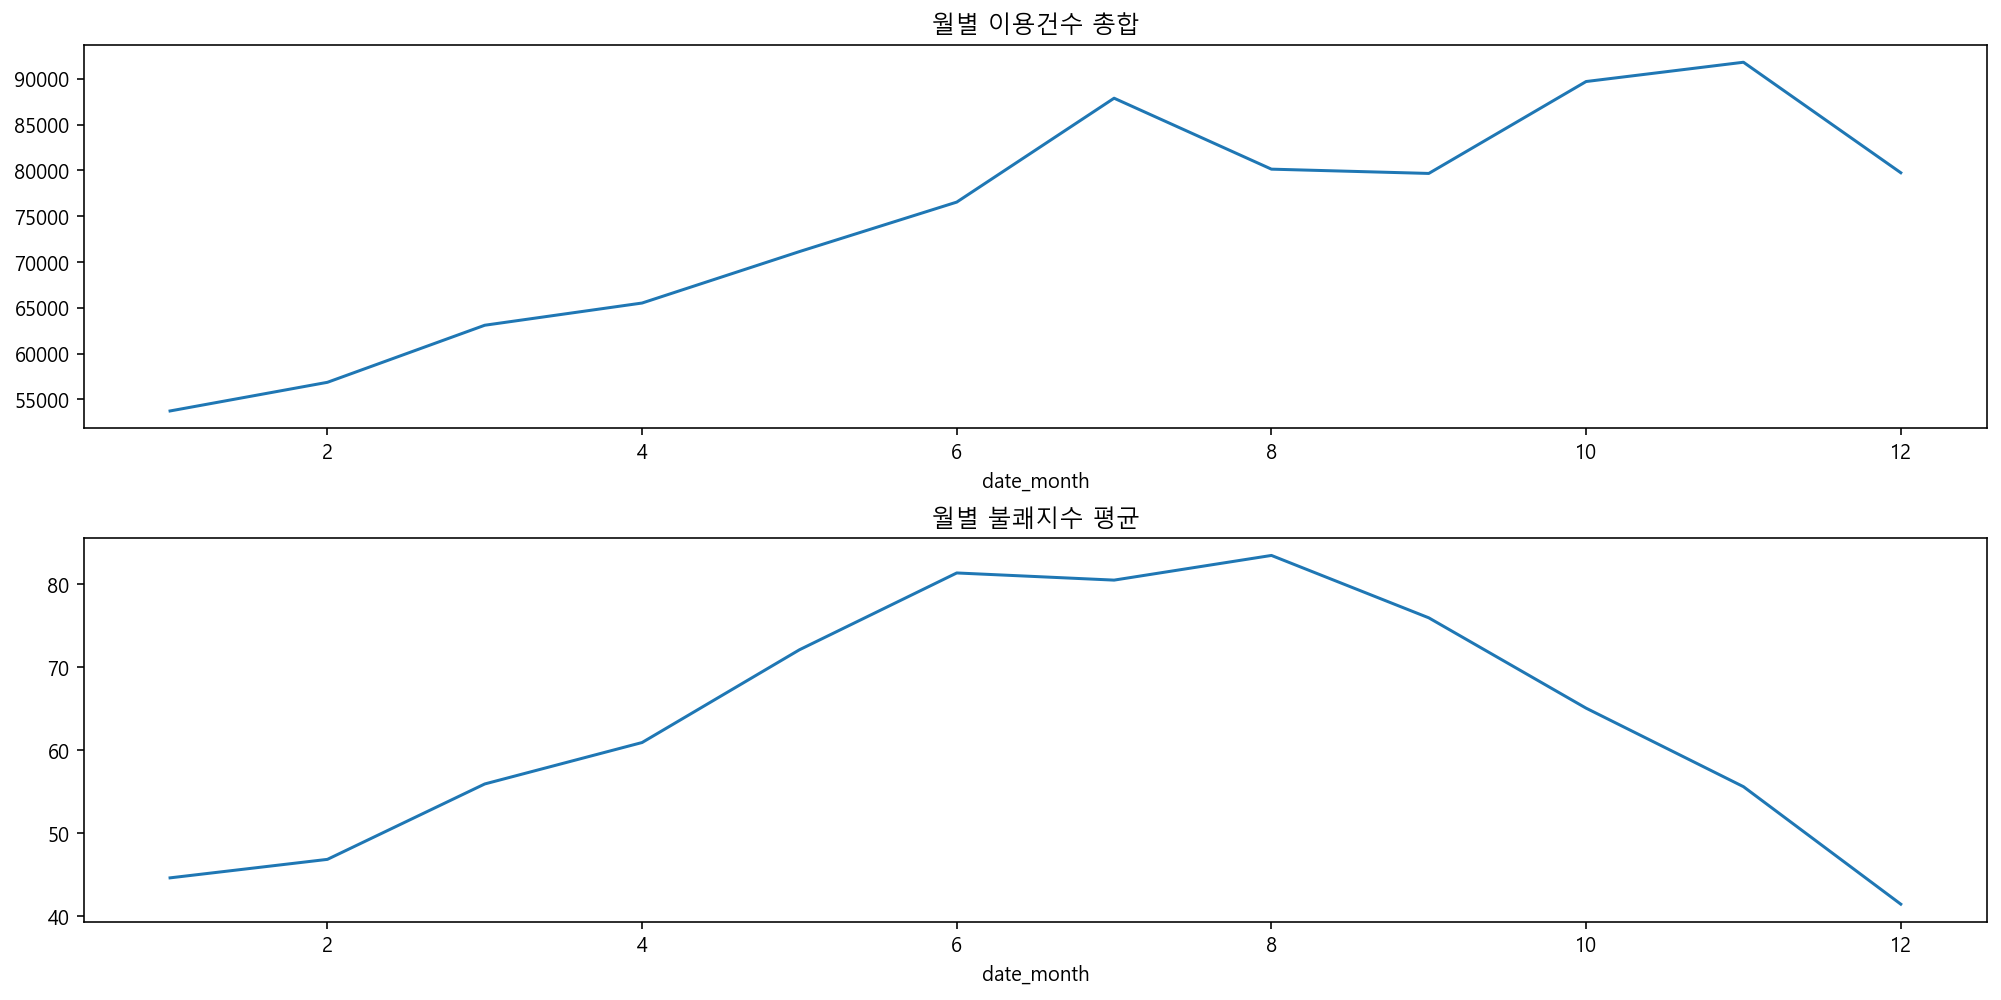

In [528]:
# 월별 이용건수 총합 & 월별 불쾌지수 평균
merge_data_temp_discomfort = merge_data.pivot_table(index='date_month', values=['count', 'discomfort'], aggfunc={'count': sum,
                                                                                    'discomfort': np.mean})

f, (ax1, ax2) = plt.subplots(2, 1)
merge_data_temp_discomfort.iloc[:, 0].plot(kind='line', figsize=(14, 7), ax=ax1, title='월별 이용건수 총합')
merge_data_temp_discomfort.iloc[:, 1].plot(kind='line', figsize=(14, 7), ax=ax2, title='월별 불쾌지수 평균')
f.tight_layout()

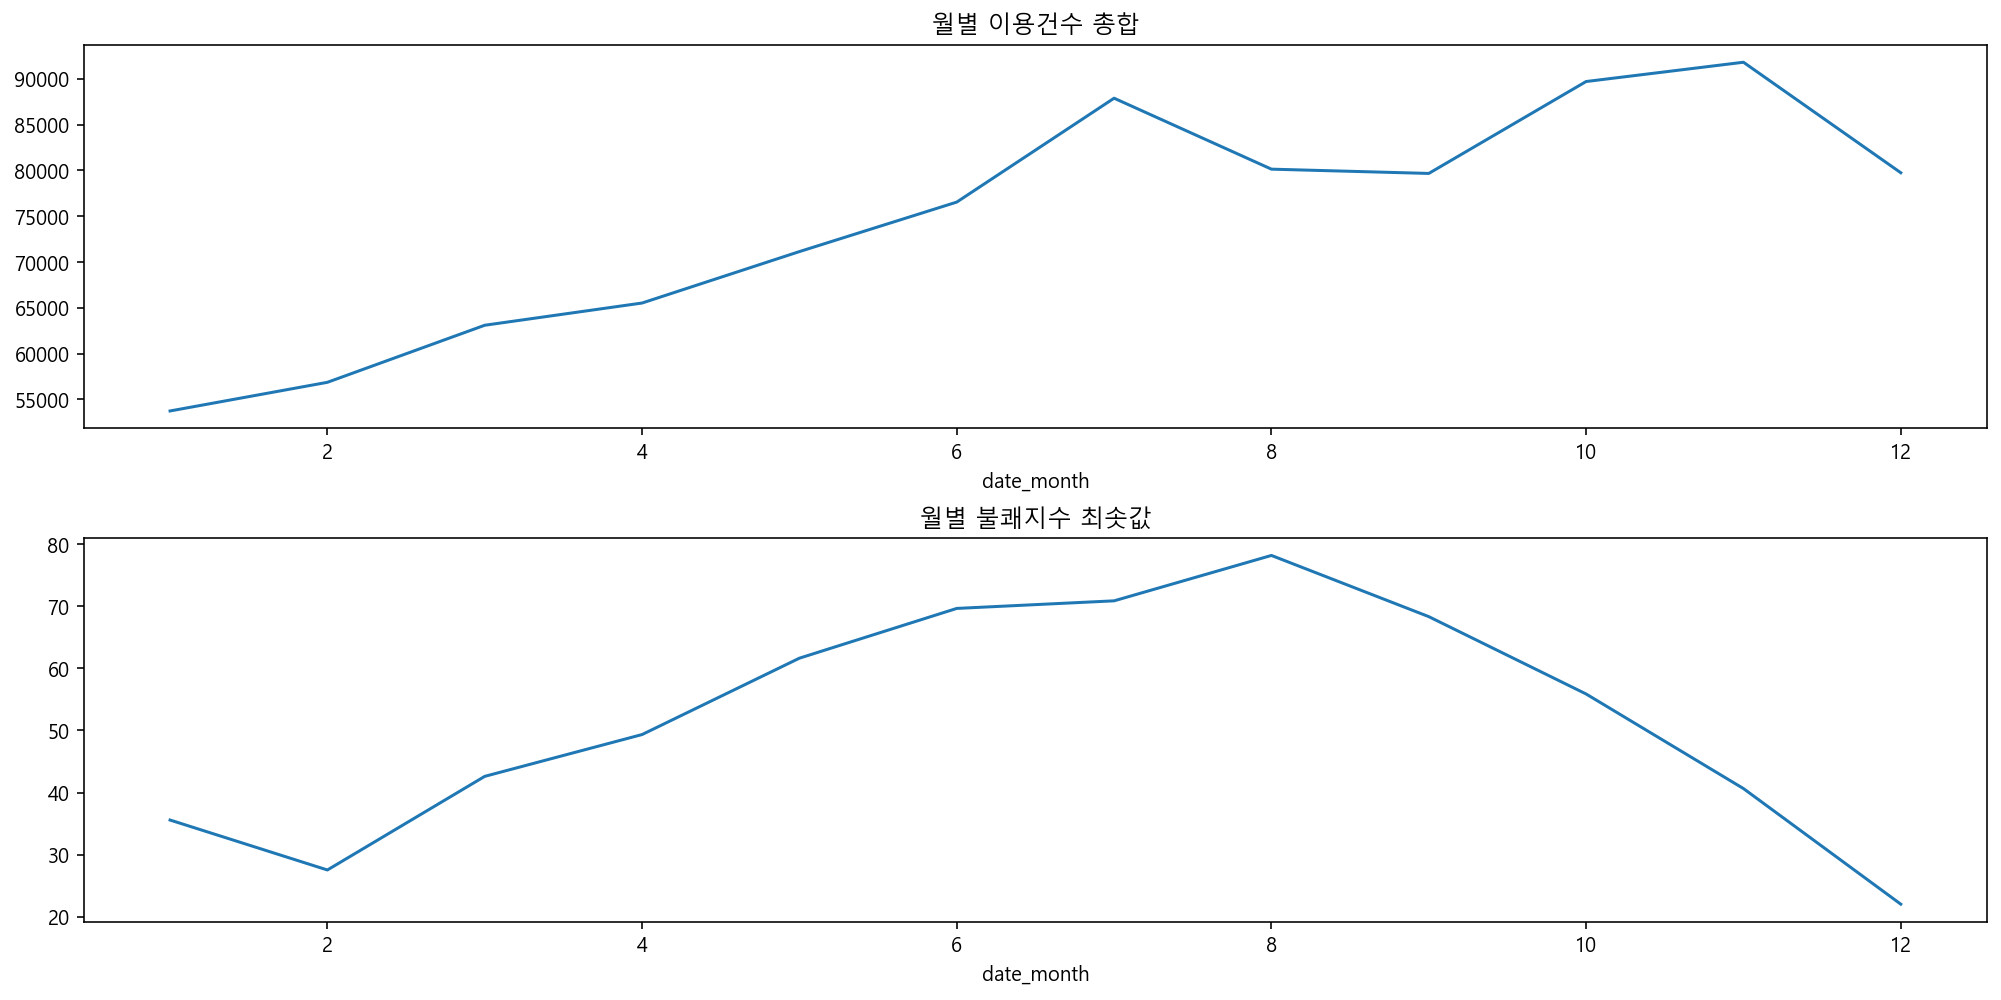

In [530]:
# 월별 이용건수 총합 & 월별 불쾌지수 최솟값
merge_data_temp_discomfort2 = merge_data.pivot_table(index='date_month', values=['count', 'discomfort'], aggfunc={'count': sum,
                                                                                    'discomfort': min})

f, (ax1, ax2) = plt.subplots(2, 1)
merge_data_temp_discomfort2.iloc[:, 0].plot(kind='line', figsize=(14, 7), ax=ax1, title='월별 이용건수 총합')
merge_data_temp_discomfort2.iloc[:, 1].plot(kind='line', figsize=(14, 7), ax=ax2, title='월별 불쾌지수 최솟값')
f.tight_layout()

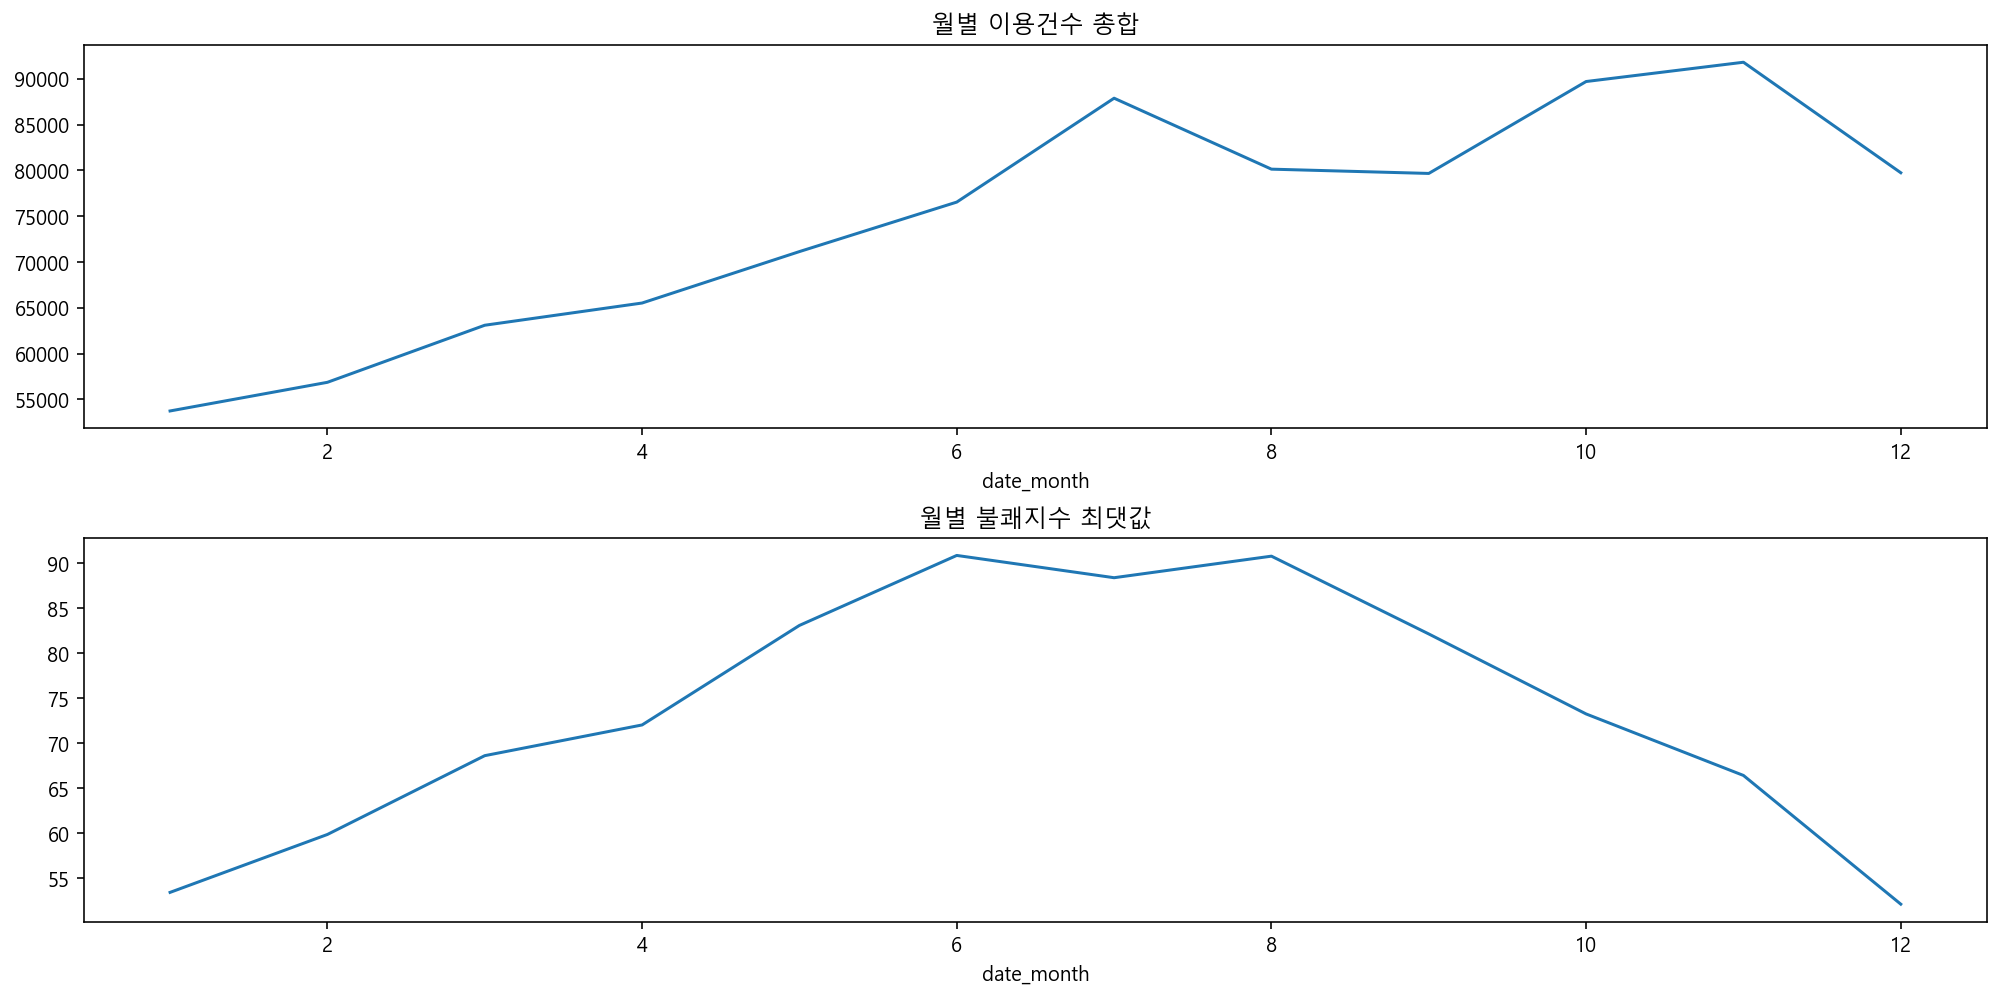

In [531]:
# 월별 이용건수 총합 & 월별 불쾌지수 최댓값
merge_data_temp_discomfort3 = merge_data.pivot_table(index='date_month', values=['count', 'discomfort'], aggfunc={'count': sum,
                                                                                    'discomfort': max})

f, (ax1, ax2) = plt.subplots(2, 1)
merge_data_temp_discomfort3.iloc[:, 0].plot(kind='line', figsize=(14, 7), ax=ax1, title='월별 이용건수 총합')
merge_data_temp_discomfort3.iloc[:, 1].plot(kind='line', figsize=(14, 7), ax=ax2, title='월별 불쾌지수 최댓값')
f.tight_layout()

* 월별 이용건수 총합과 월별 불쾌지수 평균(or 최댓값)의 추이를 비교해본 결과, 1~9월, 11~12월은 비슷한 추이

In [534]:
merge_data.columns

Index(['user_id', 'join_date', 'store_id', 'date', 'count', 'd_type_labels',
       'goods_type_labels', 'join_year', 'date_year', 'date_month',
       'date_weekday', 'ad2', 'min_temp', 'max_temp', '강수량', '습도', '적설량',
       '지면온도', '지중온도', '풍속', 'discomfort'],
      dtype='object')

## 기온 

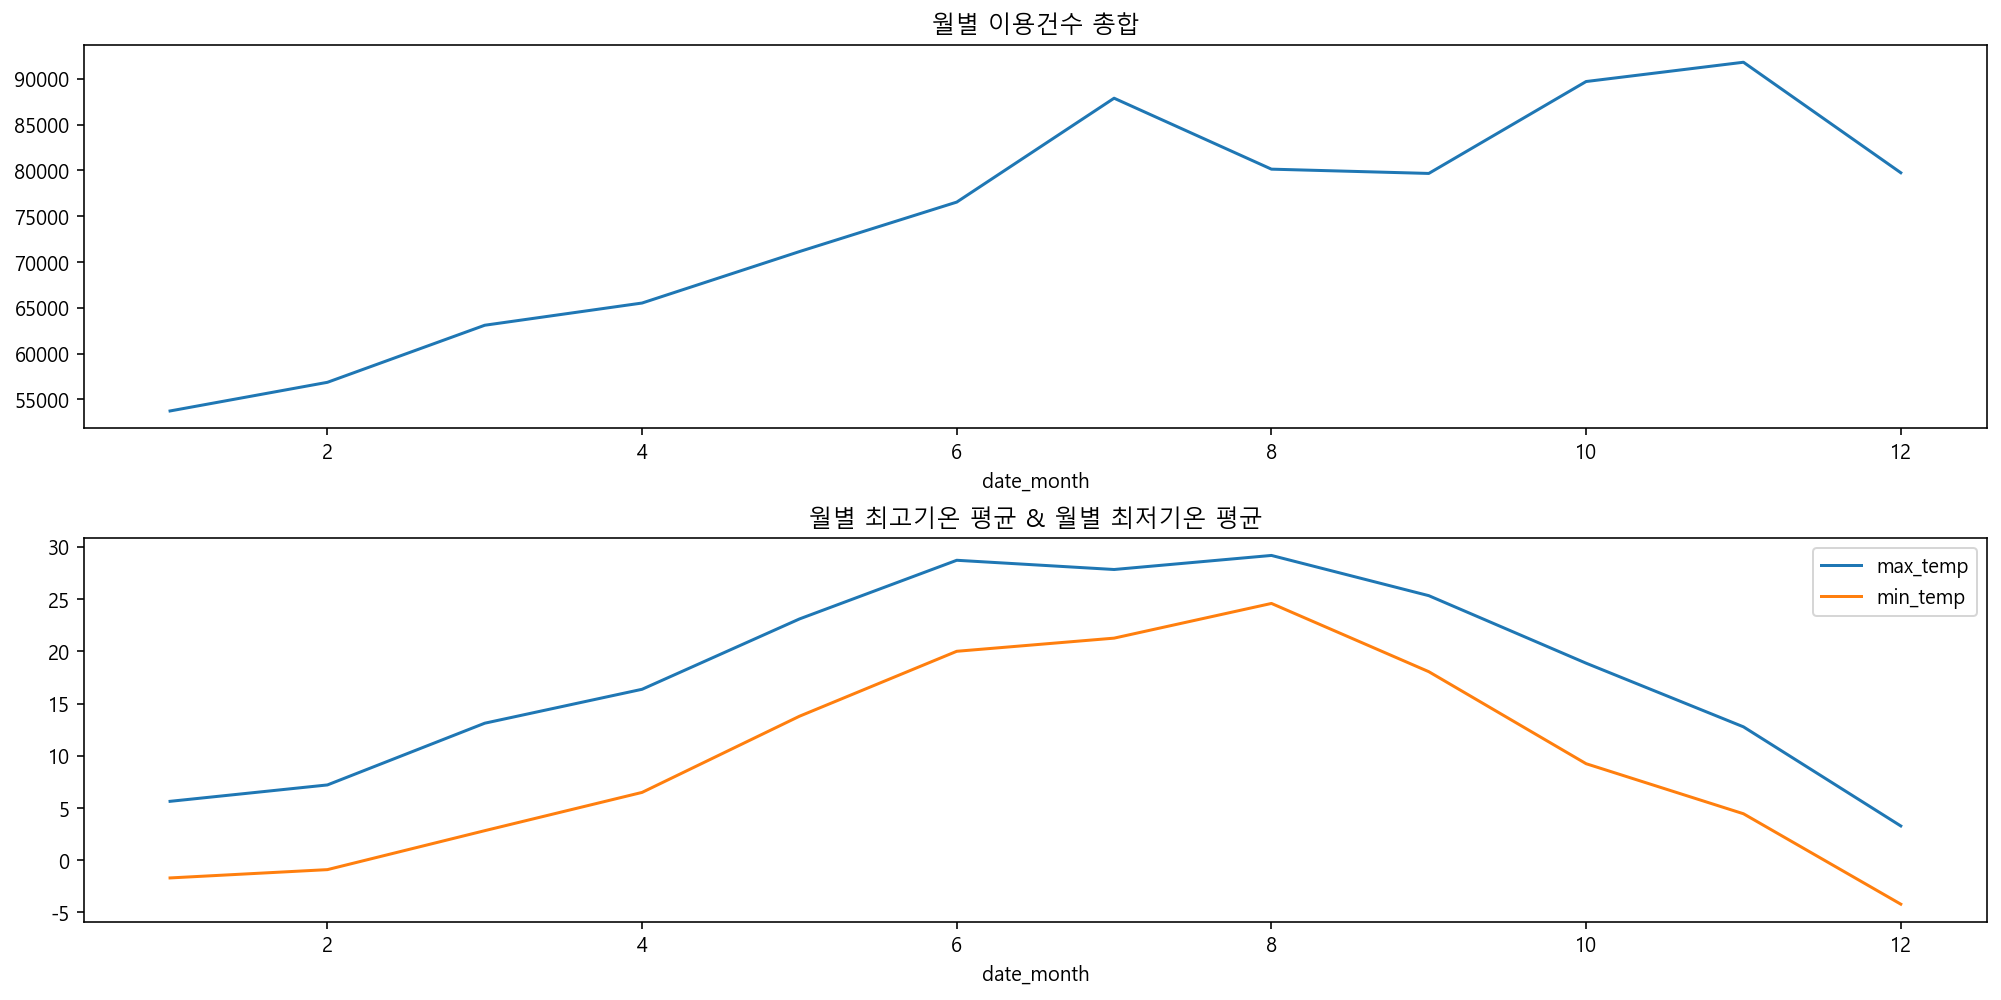

In [675]:
merge_data_temp = merge_data.pivot_table(index='date_month', values=['count', 'max_temp', 'min_temp'], 
                                                    aggfunc={'count': 'sum',
                                                            'max_temp': np.mean,
                                                            'min_temp': np.mean})

f, (ax1, ax2) = plt.subplots(2, 1)
merge_data_temp.iloc[:, 0].plot(kind='line', figsize=(14, 7), ax=ax1, title='월별 이용건수 총합')
merge_data_temp.iloc[:, 1].plot(kind='line', figsize=(14, 7), ax=ax2, title='월별 최고기온 평균 & 월별 최저기온 평균', legend=True)
merge_data_temp.iloc[:, 2].plot(kind='line', figsize=(14, 7), ax=ax2, title='월별 최고기온 평균 & 월별 최저기온 평균', legend=True)
f.tight_layout()

* 월별 이용건수(총합)와의 추이 비교 결과, 여름까지는 비슷한 추세를 보이지만, 9월부터는 다른 양상(불쾌지수와 비슷한 상황)
* 월별 불쾌지수 평균(or 최댓값)과 월별 최고기온 평균, 월별 최저기온 평균의 추이는 거의 일치

### 기온 관련 아이디어

* 기온이 높아질수록 이용건수도 같이 늘었고, 날이 추워질수록 이용건수도 늘었다. (전반적으로 우상향 그래프)
* 9월부터의 기온에 가중치를 준다면? (아직 미반영 상태)

## 지면온도 & 지중온도 

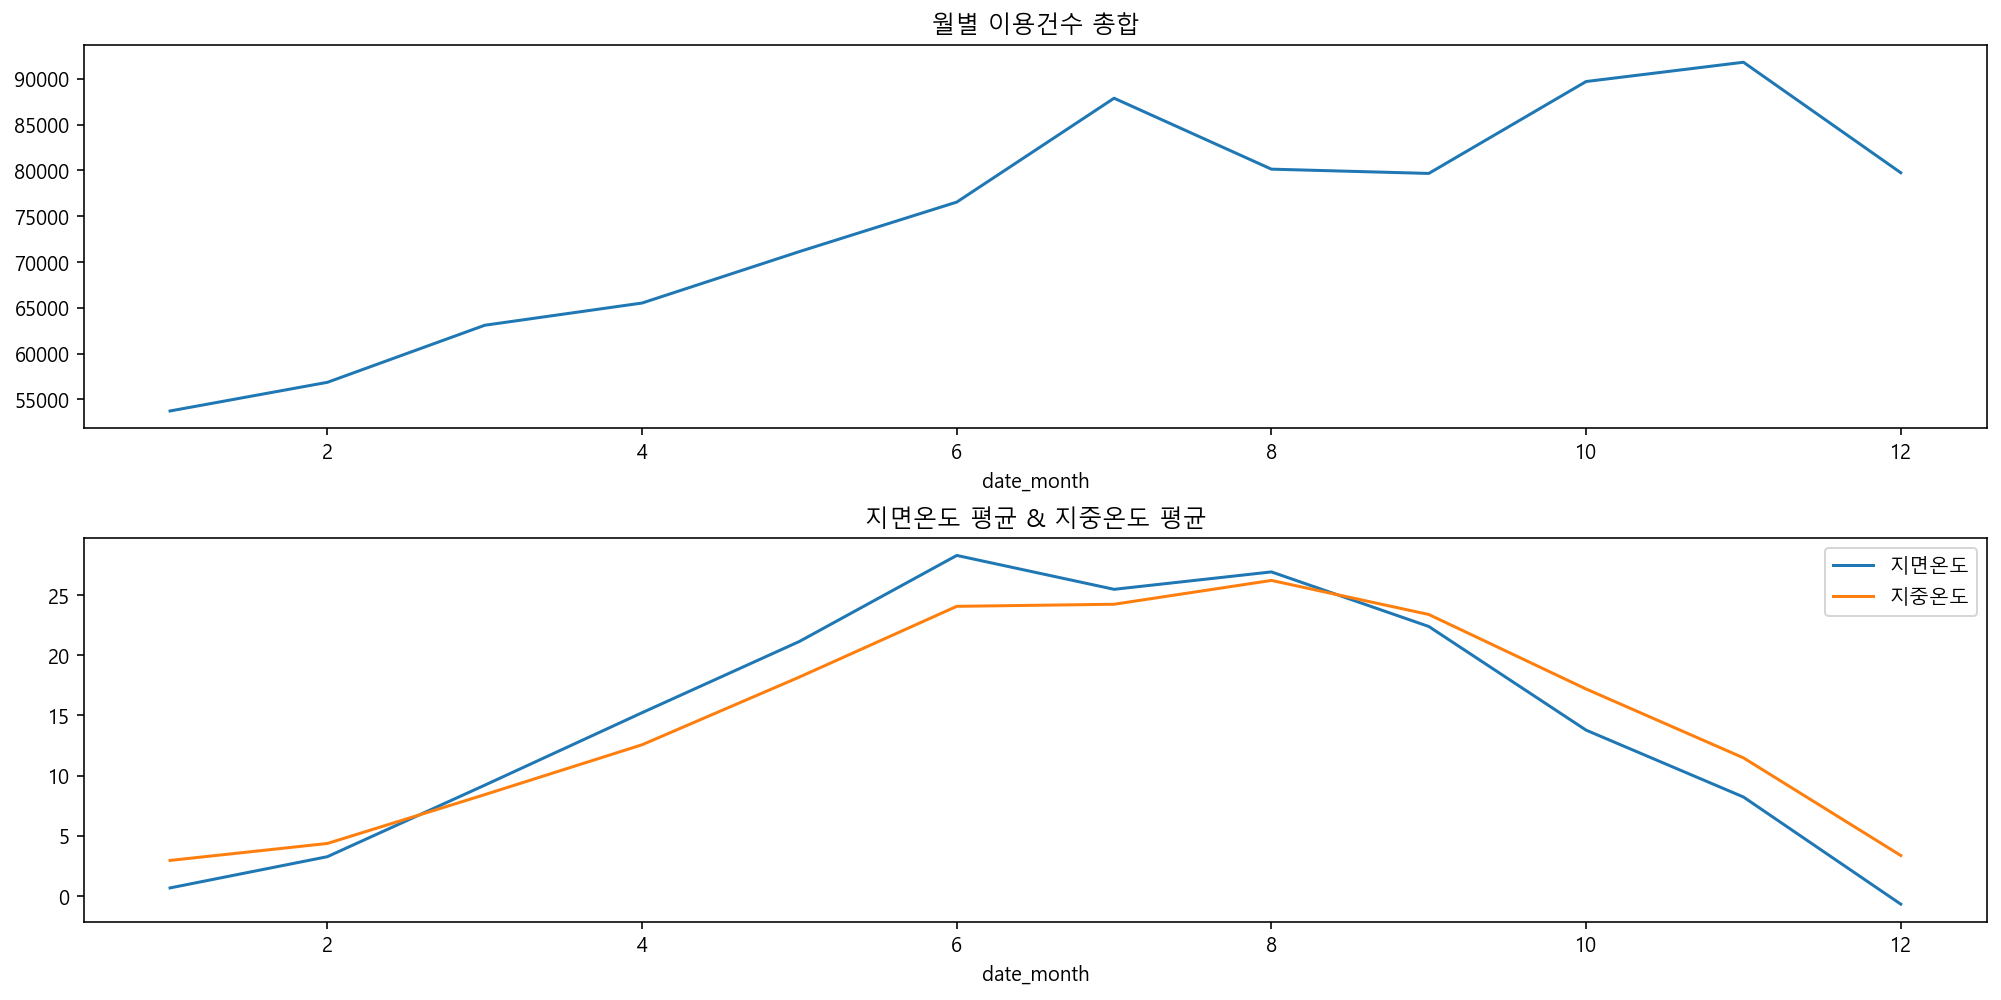

In [676]:
merge_data_ground_temp = merge_data.pivot_table(index='date_month', 
                                                values=['count', '지면온도', '지중온도'], 
                                                aggfunc={'count': 'sum',
                                                        '지면온도': np.mean,
                                                        '지중온도': np.mean})

f, (ax1, ax2) = plt.subplots(2, 1)
merge_data_ground_temp.iloc[:, 0].plot(kind='line', figsize=(14, 7), ax=ax1, title='월별 이용건수 총합')
merge_data_ground_temp.iloc[:, 1].plot(kind='line', figsize=(14, 7), ax=ax2, title='지면온도 평균 & 지중온도 평균', legend=True)
merge_data_ground_temp.iloc[:, 2].plot(kind='line', figsize=(14, 7), ax=ax2, title='지면온도 평균 & 지중온도 평균', legend=True)
f.tight_layout()

## 습도 

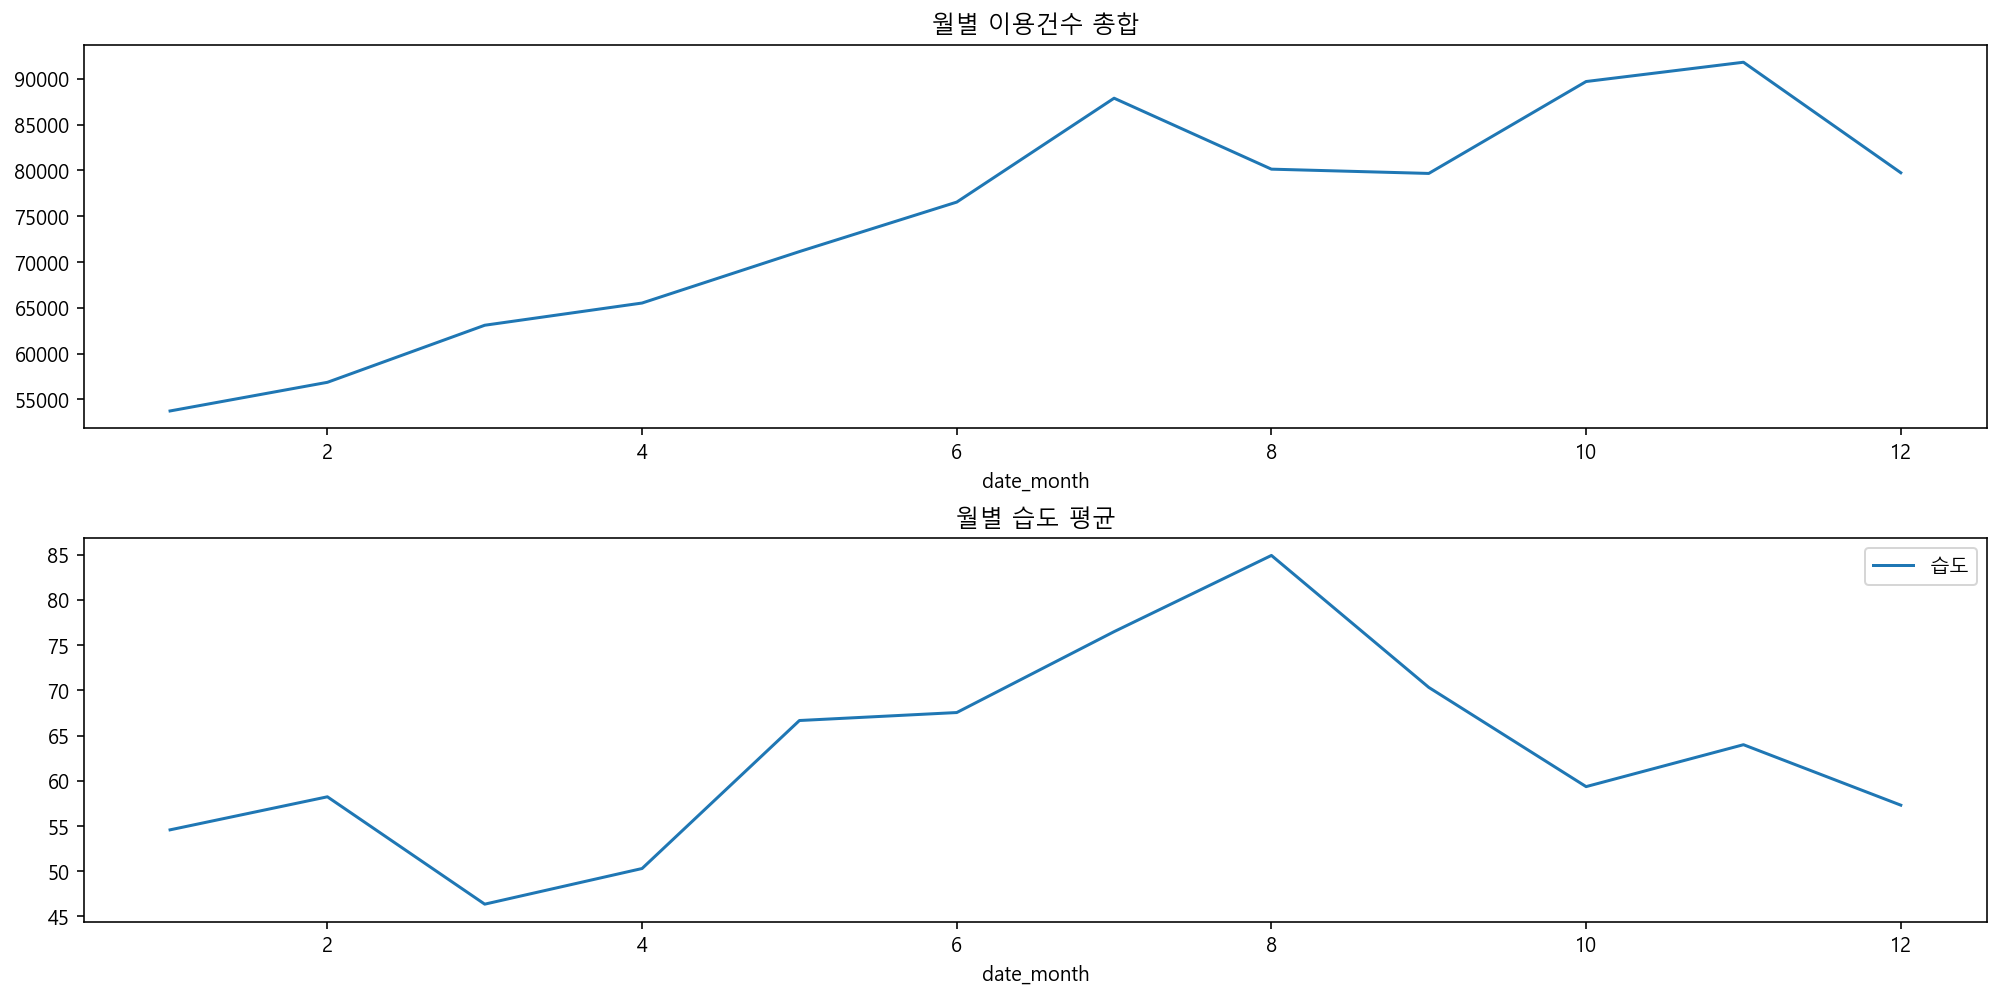

In [677]:
merge_data_ground_temp = merge_data.pivot_table(index='date_month', 
                                                values=['count', '습도'], 
                                                aggfunc={'count': 'sum',
                                                        '습도': np.mean})

f, (ax1, ax2) = plt.subplots(2, 1)
merge_data_ground_temp.iloc[:, 0].plot(kind='line', figsize=(14, 7), ax=ax1, title='월별 이용건수 총합')
merge_data_ground_temp.iloc[:, 1].plot(kind='line', figsize=(14, 7), ax=ax2, title='월별 습도 평균', legend=True)
f.tight_layout()

## 강수량 & 적설량

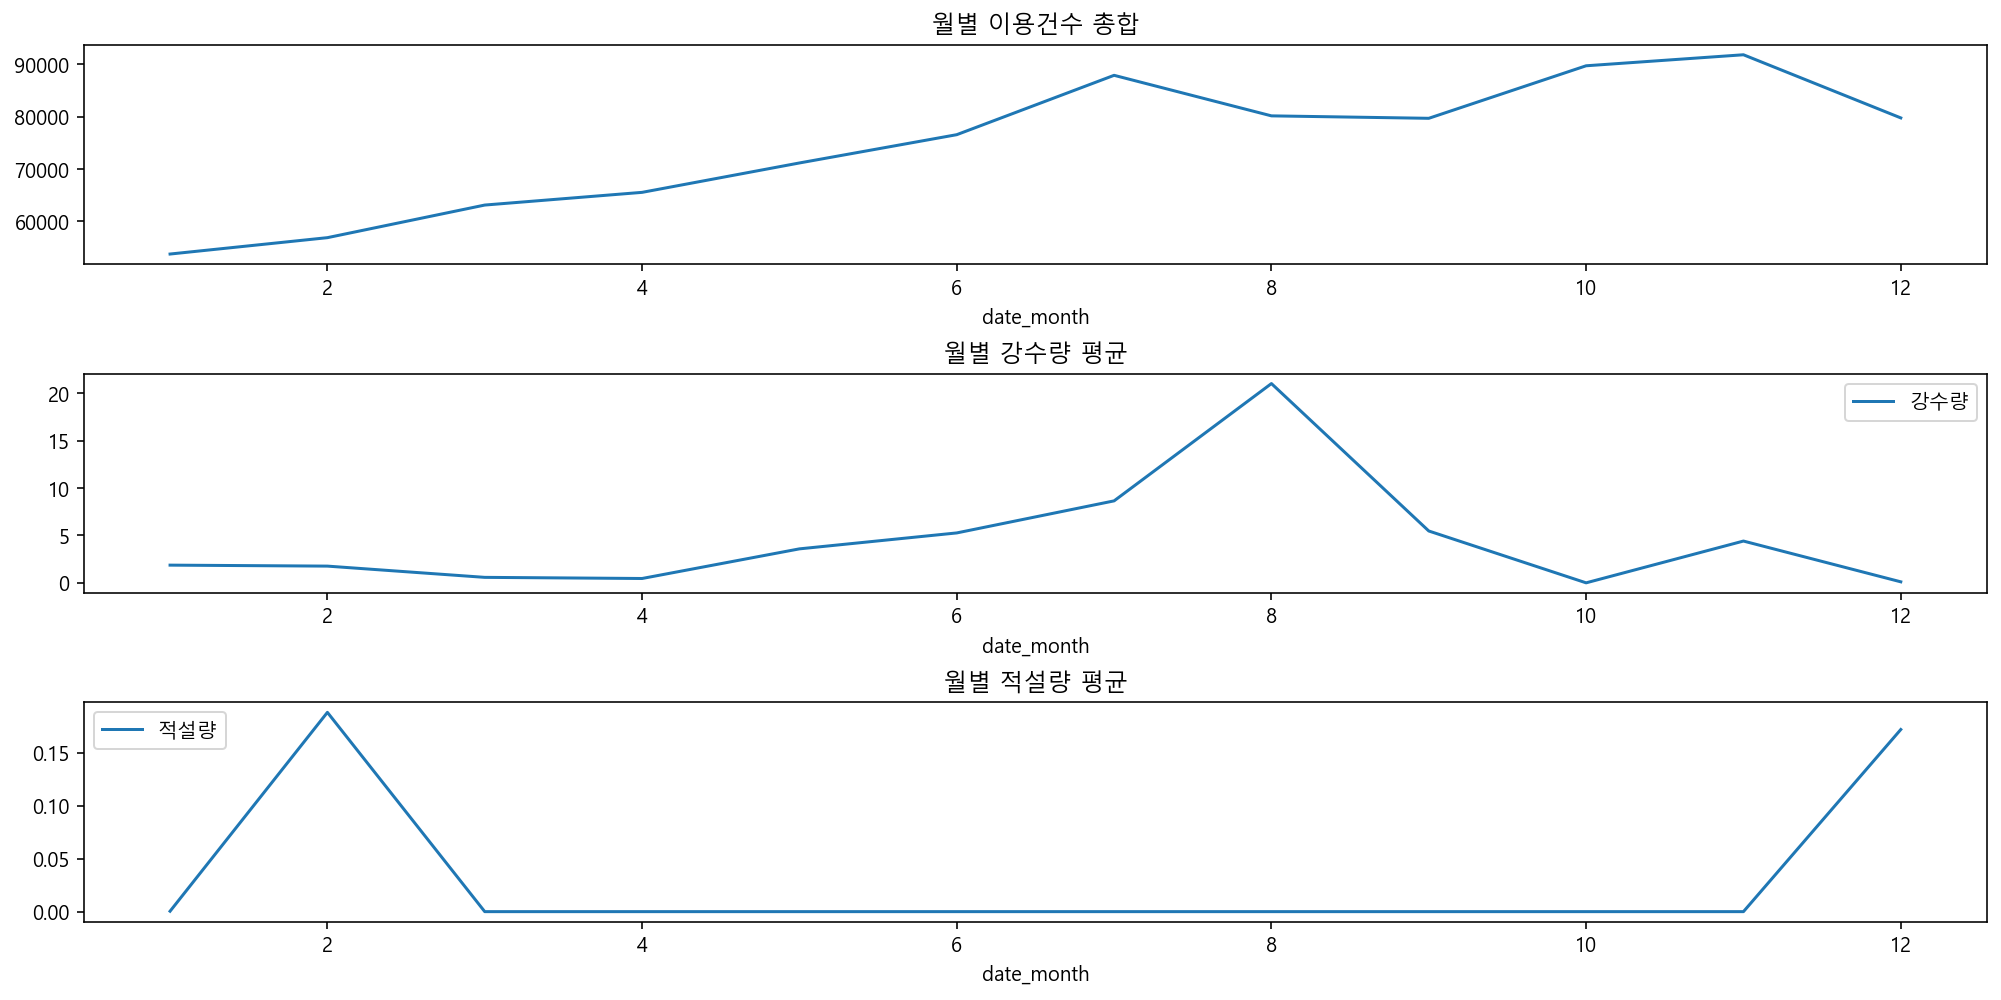

In [678]:
merge_data_ground_temp = merge_data.pivot_table(index='date_month', 
                                                values=['count', '강수량', '적설량'], 
                                                aggfunc={'count': 'sum',
                                                        '강수량': np.mean,
                                                        '적설량': np.mean})

f, (ax1, ax2, ax3) = plt.subplots(3, 1)
merge_data_ground_temp.iloc[:, 0].plot(kind='line', figsize=(14, 7), ax=ax1, title='월별 이용건수 총합')
merge_data_ground_temp.iloc[:, 1].plot(kind='line', figsize=(14, 7), ax=ax2, title='월별 강수량 평균', legend=True)
merge_data_ground_temp.iloc[:, 2].plot(kind='line', figsize=(14, 7), ax=ax3, title='월별 적설량 평균', legend=True)
f.tight_layout()

* 월별 적설량은 이용건수와 상관없어보임
* 월별 강수량에 대해선 ~7월까지 추이 비슷하고, 8~9월, 11~12월 추이 비슷

## 풍속

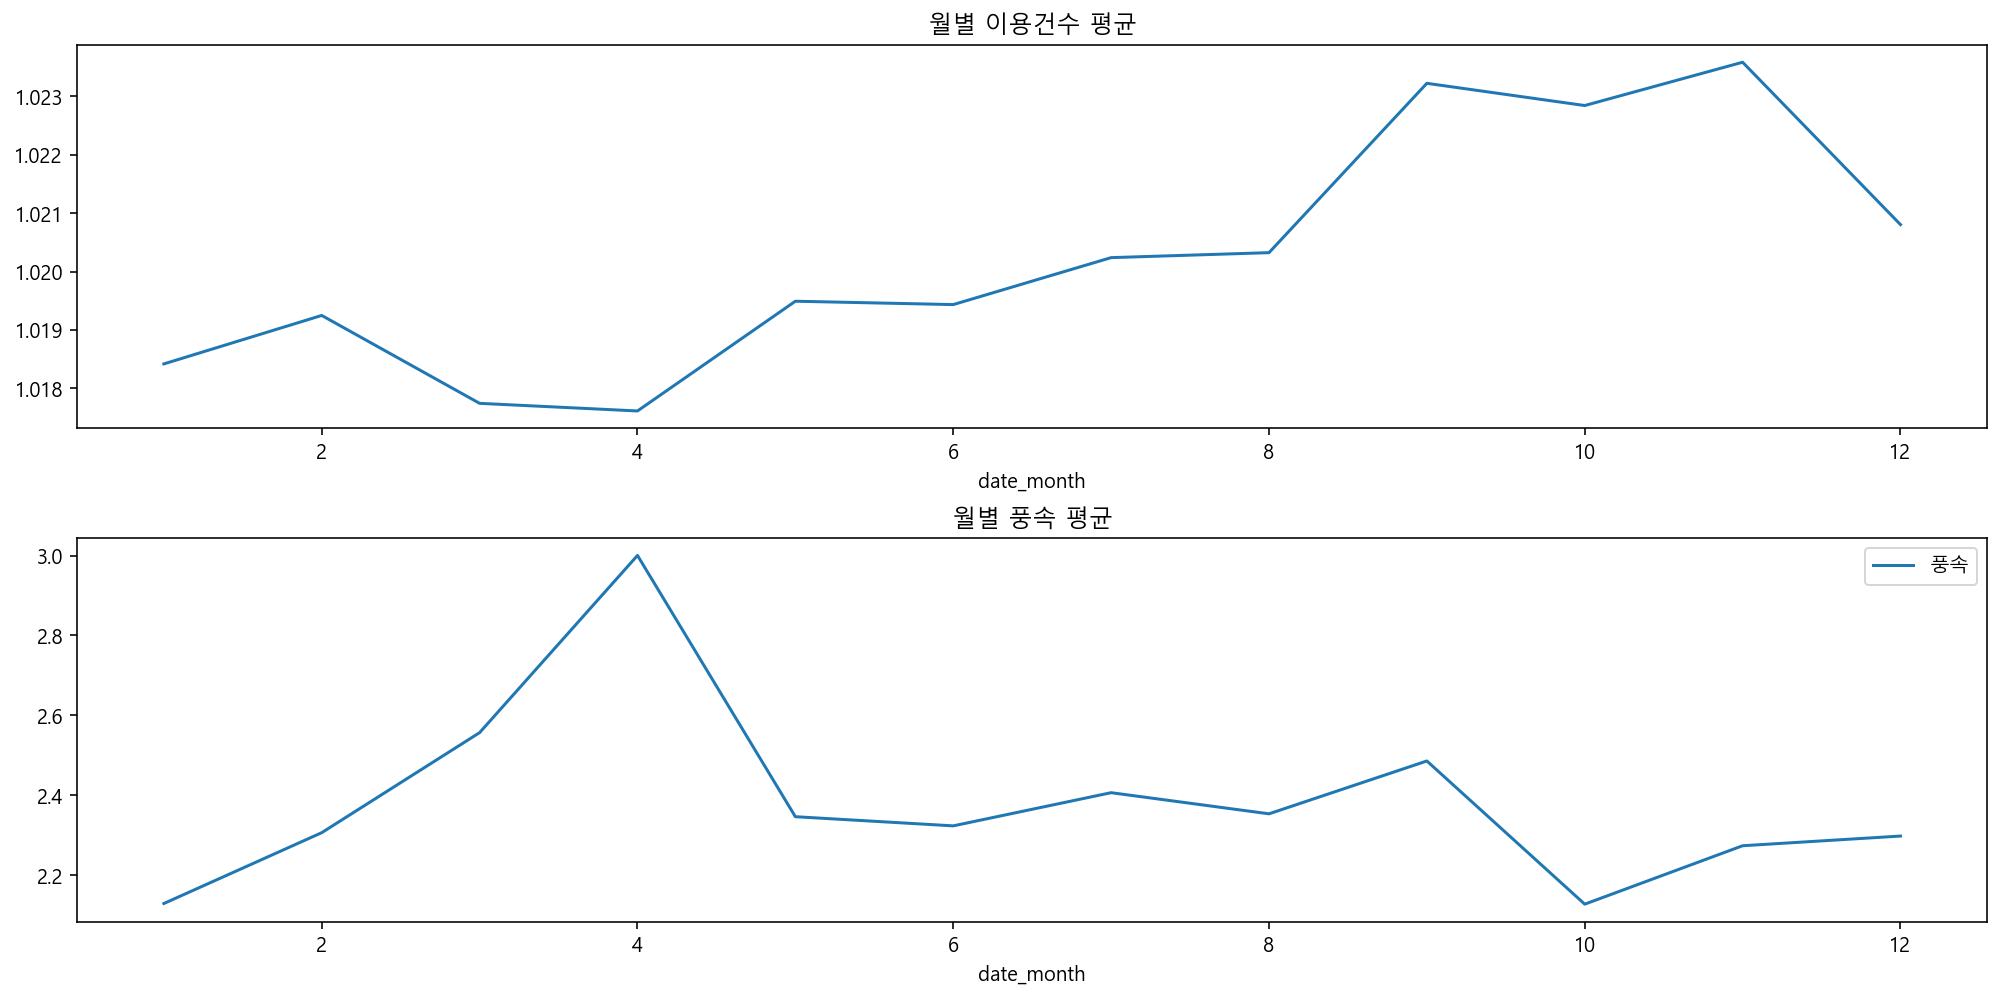

In [672]:
merge_data_ground_temp = merge_data.pivot_table(index='date_month', 
                                                values=['count', '풍속'], 
                                                aggfunc={'count': np.mean,
                                                        '풍속': np.mean})

f, (ax1, ax2) = plt.subplots(2, 1)
merge_data_ground_temp.iloc[:, 0].plot(kind='line', figsize=(14, 7), ax=ax1, title='월별 이용건수 평균')
merge_data_ground_temp.iloc[:, 1].plot(kind='line', figsize=(14, 7), ax=ax2, title='월별 풍속 평균', legend=True)
f.tight_layout()

* 풍속은 이용건수와 크게 상관없어보임

# 유의미한 피처 선정을 위한 3차 EDA(5/12)

## 데이터셋 전처리

**5/11 회의를 통해 고려해야할 변수들** <br>
* user_id
* date.weekdays
* (isholiday) 
* (date.week)
* date.day
* goods_type
* d_type
* store_id
* ad1
* retention
* join_date
* 일 평균 교통량
* 일 평균 기온
* 일 평균 강수량
* 일 평균 적설량
* 서울 기준 일교차 
* 불쾌지수

In [606]:
final = merge_data.copy()
final.head(2)

,user_id,join_date,store_id,date,count,d_type_labels,goods_type_labels,join_year,date_year,date_month,date_weekday,ad2,min_temp,max_temp,강수량,습도,적설량,지면온도,지중온도,풍속,discomfort
0,2858,2014-01-07,1892,2020-01-01,1,0,0,2014,2020,1,Wednesday,39,-5.90,0.30,0.10,62.74,0.00,-0.92,2.86,1.15,35.90
1,5647,2014-02-14,182009,2020-01-01,1,1,0,2014,2020,1,Wednesday,49,-5.90,0.30,0.10,62.74,0.00,-0.92,2.86,1.15,35.90


In [607]:
# 요일 labeling
final['weekdays'] = final['date'].dt.weekday

# 컬럼명 변경
final.rename(columns={'d_type_labels':'d_type',
                     'goods_type_labels':'goods_type',
                     'ad2':'ad1',
                     'min_temp':'일 최소 기온',
                     'max_temp':'일 최대 기온',
                     '강수량':'일 강수량총합',
                     '습도':'평균습도',
                     '적설량':'일 평균적설량',
                     '지면온도':'일 평균지면온도',
                     '지중온도':'일 평균지중온도',
                     '풍속':'일 평균풍속',
                     'discomfort':'불쾌지수'}, inplace=True)
final.head()

,user_id,join_date,store_id,date,count,d_type,goods_type,join_year,date_year,date_month,date_weekday,ad1,일 최소 기온,일 최대 기온,일 강수량총합,평균습도,일 평균적설량,일 평균지면온도,일 평균지중온도,일 평균풍속,불쾌지수,weekdays
0,2858,2014-01-07,1892,2020-01-01,1,0,0,2014,2020,1,Wednesday,39,-5.90,0.30,0.10,62.74,0.00,-0.92,2.86,1.15,35.90,2
1,5647,2014-02-14,182009,2020-01-01,1,1,0,2014,2020,1,Wednesday,49,-5.90,0.30,0.10,62.74,0.00,-0.92,2.86,1.15,35.90,2
2,33314,2014-11-20,82431,2020-01-01,1,1,0,2014,2020,1,Wednesday,63,-5.90,0.30,0.10,62.74,0.00,-0.92,2.86,1.15,35.90,2
3,37001,2014-12-04,725,2020-01-01,1,1,2,2014,2020,1,Wednesday,52,-5.90,0.30,0.10,62.74,0.00,-0.92,2.86,1.15,35.90,2
4,37819,2014-12-07,220691,2020-01-01,1,0,2,2014,2020,1,Wednesday,51,-5.90,0.30,0.10,62.74,0.00,-0.92,2.86,1.15,35.90,2


In [608]:
# 필요없는 컬럼 제거
final = final.drop(columns=['join_year', 'date_weekday'])
final.head(3)

,user_id,join_date,store_id,date,count,d_type,goods_type,date_year,date_month,ad1,일 최소 기온,일 최대 기온,일 강수량총합,평균습도,일 평균적설량,일 평균지면온도,일 평균지중온도,일 평균풍속,불쾌지수,weekdays
0,2858,2014-01-07,1892,2020-01-01,1,0,0,2020,1,39,-5.90,0.30,0.10,62.74,0.00,-0.92,2.86,1.15,35.90,2
1,5647,2014-02-14,182009,2020-01-01,1,1,0,2020,1,49,-5.90,0.30,0.10,62.74,0.00,-0.92,2.86,1.15,35.90,2
2,33314,2014-11-20,82431,2020-01-01,1,1,0,2020,1,63,-5.90,0.30,0.10,62.74,0.00,-0.92,2.86,1.15,35.90,2


## EDA

### 전체 상관관계 확인

<AxesSubplot:>

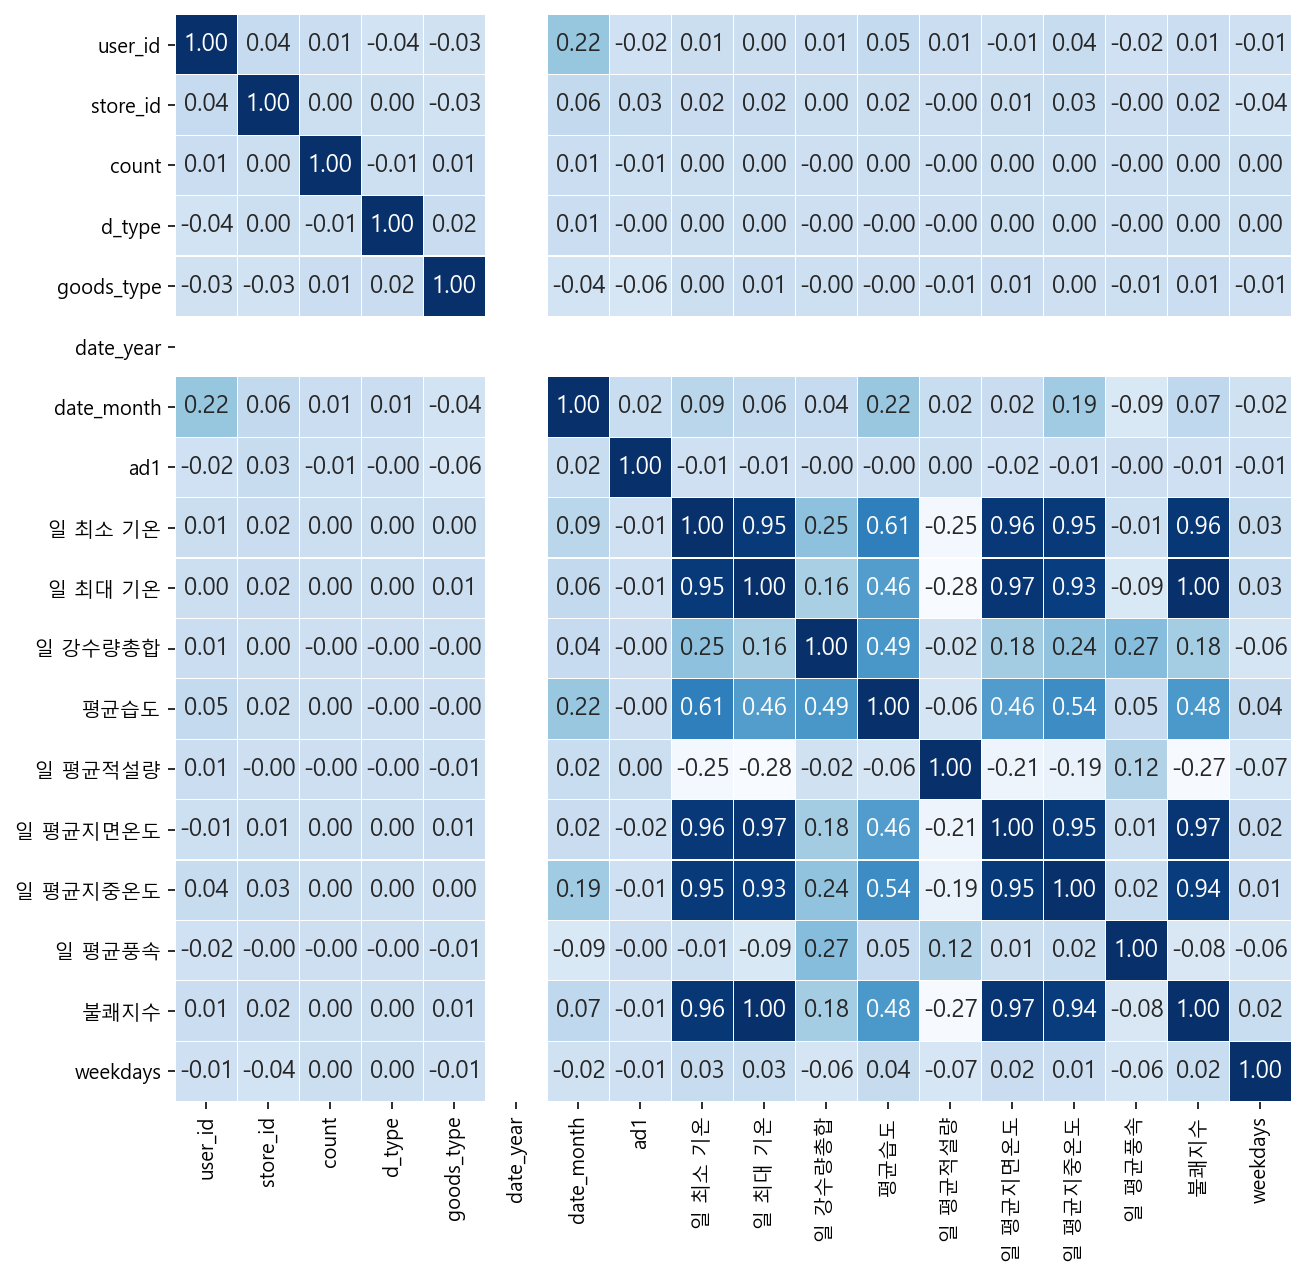

In [612]:
plt.figure(figsize=(10, 10))
sns.heatmap(data=final.corr(),
           annot=True,
           annot_kws={'size':12},
           cmap='Blues',
           cbar=False,
           linewidths=0.1,
           fmt='.2f')

* 일 최소기온 & 일 평균지면온도 & 일 평균지중온도 & 평균습도 & 일 최대기온 
* 일 강수량총합은 평균습도와 일 최소기온과 상관관계

### count = 1 제외하고 상관관계 확인 

In [614]:
final.head()

,user_id,join_date,store_id,date,count,d_type,goods_type,date_year,date_month,ad1,일 최소 기온,일 최대 기온,일 강수량총합,평균습도,일 평균적설량,일 평균지면온도,일 평균지중온도,일 평균풍속,불쾌지수,weekdays
0,2858,2014-01-07,1892,2020-01-01,1,0,0,2020,1,39,-5.90,0.30,0.10,62.74,0.00,-0.92,2.86,1.15,35.90,2
1,5647,2014-02-14,182009,2020-01-01,1,1,0,2020,1,49,-5.90,0.30,0.10,62.74,0.00,-0.92,2.86,1.15,35.90,2
2,33314,2014-11-20,82431,2020-01-01,1,1,0,2020,1,63,-5.90,0.30,0.10,62.74,0.00,-0.92,2.86,1.15,35.90,2
3,37001,2014-12-04,725,2020-01-01,1,1,2,2020,1,52,-5.90,0.30,0.10,62.74,0.00,-0.92,2.86,1.15,35.90,2
4,37819,2014-12-07,220691,2020-01-01,1,0,2,2020,1,51,-5.90,0.30,0.10,62.74,0.00,-0.92,2.86,1.15,35.90,2


In [620]:
print(len(final))
print(len(final.loc[final['count'] != 1]))

877812
15108


* count가 1인 경우를 제외하면 15108개 데이터밖에 남지 않음
* 데이터 유실이 크지만, 일단 count가 1이 아닌 경우들만으로 상관관계 확인

<AxesSubplot:>

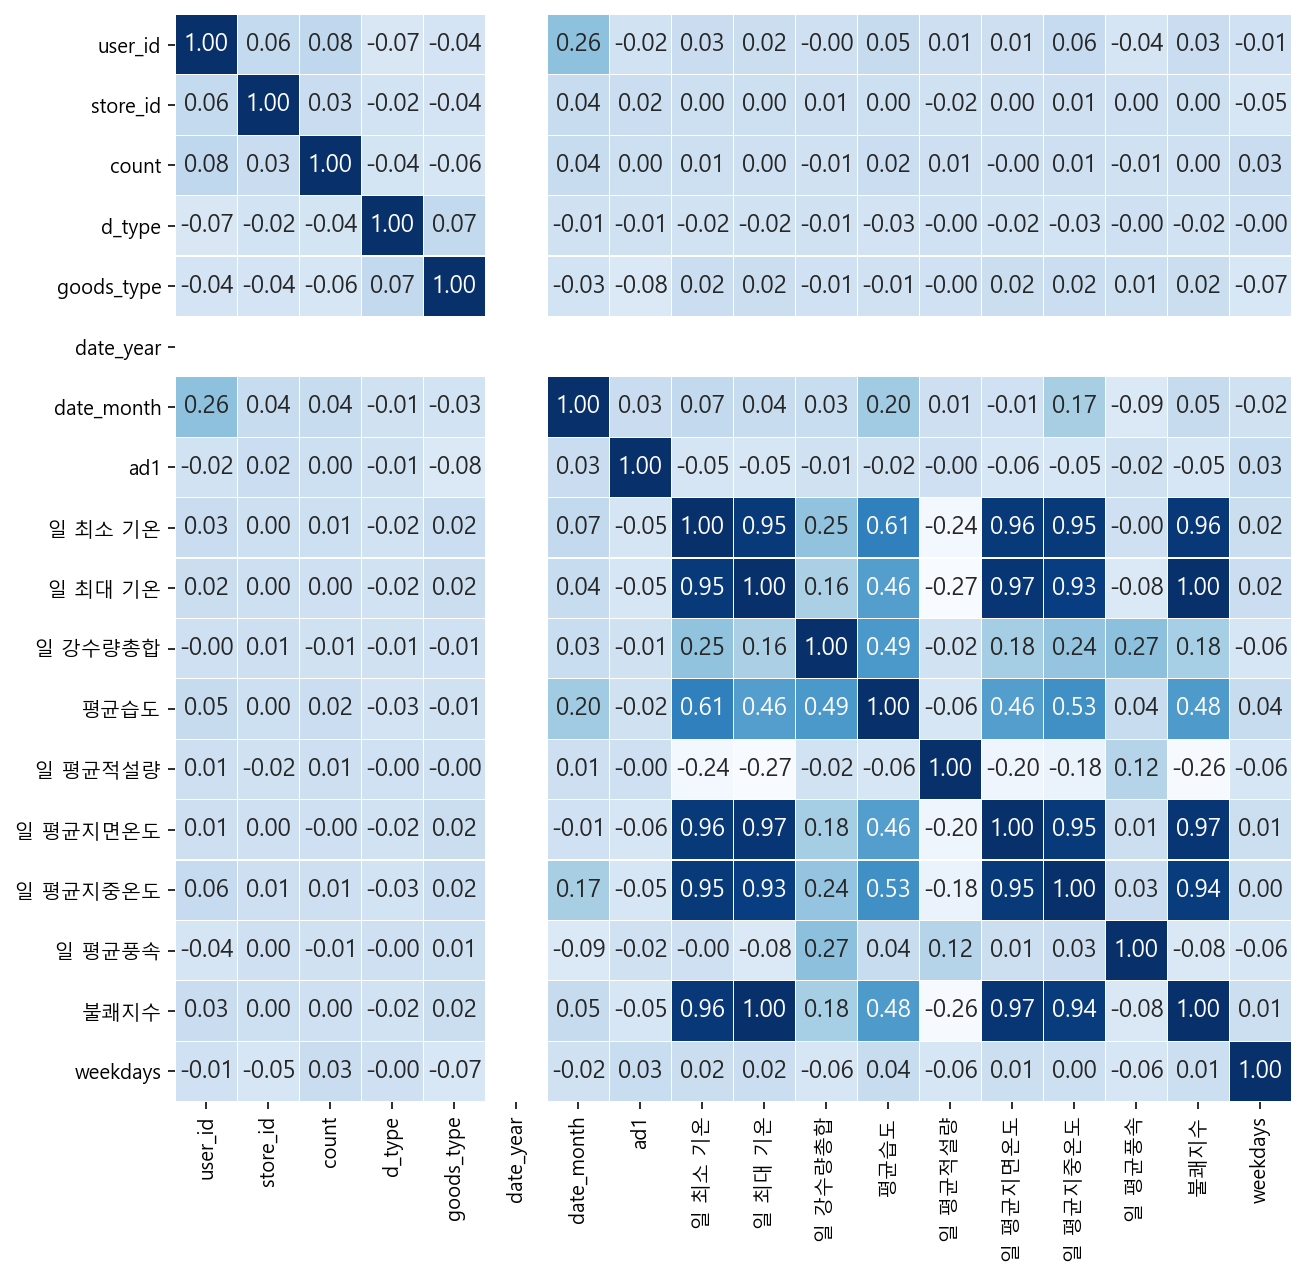

In [621]:
plt.figure(figsize=(10, 10))
sns.heatmap(data=final.loc[final['count'] != 1].corr(),
           annot=True,
           annot_kws={'size':12},
           cmap='Blues',
           cbar=False,
           linewidths=0.1,
           fmt='.2f')

* count가 1인 경우를 제외해도 각 컬럼 간 상관관계는 크게 달라지지 않음
* 제외하는 게 의미없을 것으로 판단되어 count가 1인 경우도 전부 포함하여 분석 진행

* **날씨 관련 피처들 간에 상관관계 높은 것들 제거 필요(다중공선성 문제 방지 목적)**

### 상관관계 높은 날씨 피처들 제거(1차)

**제거 기준**
* 날씨 데이터 중 상관관계가 서로 높은 피처들은 소거 
* 종속변수인 count와 상관관계가 높은 피처는 남김 --> 날씨 변수들은 count와 상관관계 0

In [679]:
final_test1 = final.copy()
final_test1.head(2)

,user_id,join_date,store_id,date,count,d_type,goods_type,date_year,date_month,ad1,일 최소 기온,일 최대 기온,일 강수량총합,평균습도,일 평균적설량,일 평균지면온도,일 평균지중온도,일 평균풍속,불쾌지수,weekdays
0,2858,2014-01-07,1892,2020-01-01,1,0,0,2020,1,39,-5.90,0.30,0.10,62.74,0.00,-0.92,2.86,1.15,35.90,2
1,5647,2014-02-14,182009,2020-01-01,1,1,0,2020,1,49,-5.90,0.30,0.10,62.74,0.00,-0.92,2.86,1.15,35.90,2


* 병합데이터 EDA를 통해 날씨 변수들 중 월별 이용건수와 비슷한 추이 형태가 겹쳤던 **불쾌지수** 와 **강수량**만 남기고 나머지 전부 제거

In [683]:
final_test1.drop(columns=['일 최소 기온', '일 최대 기온', '평균습도', '일 평균적설량', '일 평균지면온도', '일 평균지중온도',
                         '일 평균풍속'], inplace=True)
final_test1.head(2)

,user_id,join_date,store_id,date,count,d_type,goods_type,date_year,date_month,ad1,일 강수량총합,불쾌지수,weekdays
0,2858,2014-01-07,1892,2020-01-01,1,0,0,2020,1,39,0.10,35.90,2
1,5647,2014-02-14,182009,2020-01-01,1,1,0,2020,1,49,0.10,35.90,2


# Random Forest feature importance

## train, test data 분리
* 2020.01.01~2020.09.30 : Training Data
* 2020.10.01~2020.12.31 : Test Data
* 2020.10.01~2020.12.31 구간에 대한 MSE, MAE 계산값

In [626]:
train = final.loc[(final['date'] >= '2020-01-01') & (final['date'] <= '2020-09-30')]
test = final.loc[(final['date'] >= '2020-10-01') & (final['date'] <= '2020-12-31')]
X_train = train.drop(columns='count')
y_train = train['count']
X_test = test.drop(columns='count')
y_test = test['count']

In [629]:
X_train.drop(columns=['join_date', 'date'], inplace=True)
X_test.drop(columns=['join_date', 'date'], inplace=True)

In [633]:
model = RandomForestRegressor(random_state=random_state)
# training
model.fit(X_train, y_train)
# prediction
y_pred = model.predict(X_test)

In [636]:
features = X_train.columns.values

## 변수 중요도

In [637]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# Scatter plot 
trace = go.Scatter(
    y = model.feature_importances_,
    x = features,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = model.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = features
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [640]:
x, y = (list(x) for x in zip(*sorted(zip(model.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Random Forest Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 600, height = 1000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

In [650]:
# X_train2 = sm.add_constant(X_train)
# model2 = sm.OLS(y_train, X_train2).fit()
# model2.summary()

# Modeling

## Random Foreset

### 모의 테스트

In [556]:
merge_data.head(2)

,user_id,join_date,store_id,date,count,d_type_labels,goods_type_labels,join_year,date_year,date_month,...,ad2,min_temp,max_temp,강수량,습도,적설량,지면온도,지중온도,풍속,discomfort
0,2858,2014-01-07,1892,2020-01-01,1,0,0,2014,2020,1,...,39,-5.90,0.30,0.10,62.74,0.00,-0.92,2.86,1.15,35.90
1,5647,2014-02-14,182009,2020-01-01,1,1,0,2014,2020,1,...,49,-5.90,0.30,0.10,62.74,0.00,-0.92,2.86,1.15,35.90


In [565]:
final_data = merge_data.drop(columns=['join_date', 'date', 'date_year', 'date_weekday'])
final_data.head()

,user_id,store_id,count,d_type_labels,goods_type_labels,join_year,date_month,ad2,min_temp,max_temp,강수량,습도,적설량,지면온도,지중온도,풍속,discomfort
0,2858,1892,1,0,0,2014,1,39,-5.90,0.30,0.10,62.74,0.00,-0.92,2.86,1.15,35.90
1,5647,182009,1,1,0,2014,1,49,-5.90,0.30,0.10,62.74,0.00,-0.92,2.86,1.15,35.90
2,33314,82431,1,1,0,2014,1,63,-5.90,0.30,0.10,62.74,0.00,-0.92,2.86,1.15,35.90
3,37001,725,1,1,2,2014,1,52,-5.90,0.30,0.10,62.74,0.00,-0.92,2.86,1.15,35.90
4,37819,220691,1,0,2,2014,1,51,-5.90,0.30,0.10,62.74,0.00,-0.92,2.86,1.15,35.90


In [566]:
from sklearn.ensemble import RandomForestRegressor

x = final_data.drop(columns='count')
y = final_data['count']   
print(x.shape)
print(y.shape)

(877812, 16)
(877812,)


In [567]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [568]:
model = RandomForestRegressor()
# training
model.fit(X_train, y_train)
# prediction
y_pred = model.predict(X_test)
y_pred

array([1.01, 1.  , 1.  , ..., 1.01, 1.02, 1.  ])

In [575]:
mse = mean_squared_error(y_pred, y_test)
mae = mean_absolute_error(y_pred, y_test)
print(f"mse: {round(mse, 3)}, mae: {round(mae, 2)}")

mse: 0.036, mae: 0.04


In [582]:
y_pred.tolist()[:10]

[1.01, 1.0, 1.0, 1.0, 1.01, 1.01, 1.07, 1.04, 1.0, 1.03]

--> 모의테스트는 train_test_split으로 데이터셋을 분리했지만, 다음 테스트부터는 9월 30일 기준으로 분리 후 진행

### 3차 EDA 후 1차 테스트

#### 상관관계 높은 날씨 피처 제거 전 테스트 (데이터: final_test2)

In [680]:
final_test2 = final.copy()
final_test2.head(3)

,user_id,join_date,store_id,date,count,d_type,goods_type,date_year,date_month,ad1,일 최소 기온,일 최대 기온,일 강수량총합,평균습도,일 평균적설량,일 평균지면온도,일 평균지중온도,일 평균풍속,불쾌지수,weekdays
0,2858,2014-01-07,1892,2020-01-01,1,0,0,2020,1,39,-5.90,0.30,0.10,62.74,0.00,-0.92,2.86,1.15,35.90,2
1,5647,2014-02-14,182009,2020-01-01,1,1,0,2020,1,49,-5.90,0.30,0.10,62.74,0.00,-0.92,2.86,1.15,35.90,2
2,33314,2014-11-20,82431,2020-01-01,1,1,0,2020,1,63,-5.90,0.30,0.10,62.74,0.00,-0.92,2.86,1.15,35.90,2


In [681]:
train = final_test2.loc[(final_test2['date'] >= '2020-01-01') & (final_test2['date'] <= '2020-09-30')]
test = final_test2.loc[(final_test2['date'] >= '2020-10-01') & (final_test2['date'] <= '2020-12-31')]
X_train = train.drop(columns='count')
y_train = train['count']
X_test = test.drop(columns='count')
y_test = test['count']

X_train.drop(columns=['join_date', 'date'], inplace=True)
X_test.drop(columns=['join_date', 'date'], inplace=True)

In [687]:
model = RandomForestRegressor(random_state=random_state)
# training
model.fit(X_train, y_train)
# prediction
y_pred = model.predict(X_test)

In [688]:
mse = mean_squared_error(y_pred, y_test)
mae = mean_absolute_error(y_pred, y_test)
print(f"mse: {round(mse, 3)}, mae: {round(mae, 2)}")

mse: 0.069, mae: 0.12


#### 상관관계 높은 날씨 피처 제거 후 테스트 (데이터: final_test1)

In [686]:
final_test1.head(2)

,user_id,join_date,store_id,date,count,d_type,goods_type,date_year,date_month,ad1,일 강수량총합,불쾌지수,weekdays
0,2858,2014-01-07,1892,2020-01-01,1,0,0,2020,1,39,0.10,35.90,2
1,5647,2014-02-14,182009,2020-01-01,1,1,0,2020,1,49,0.10,35.90,2


In [689]:
train = final_test1.loc[(final_test1['date'] >= '2020-01-01') & (final_test1['date'] <= '2020-09-30')]
test = final_test1.loc[(final_test1['date'] >= '2020-10-01') & (final_test1['date'] <= '2020-12-31')]
X_train = train.drop(columns='count')
y_train = train['count']
X_test = test.drop(columns='count')
y_test = test['count']

X_train.drop(columns=['join_date', 'date'], inplace=True)
X_test.drop(columns=['join_date', 'date'], inplace=True)

In [ ]:
model = RandomForestRegressor(random_state=random_state)
# training
model.fit(X_train, y_train)
# prediction
y_pred = model.predict(X_test)

In [ ]:
mse = mean_squared_error(y_pred, y_test)
mae = mean_absolute_error(y_pred, y_test)
print(f"mse: {round(mse, 3)}, mae: {round(mae, 2)}")